<a href="https://colab.research.google.com/github/arkeodev/demistify_deep_learning_applications/blob/main/Simple_Diffusion_Models/diffusion_models.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

$$
\begin{array}{c}
\text{$\Large in-der-Welt-sein$} \\
{\text{{$\small Martin\ Heidegger$}}} \\
\end{array}
$$

# Understanding Diffusion Models in Deep Learning

## Introduction

Diffusion Models are a relatively recent addition to the family of generative models, gaining prominence for their impressive ability to generate high-quality, high-resolution images. These models work by gradually transforming a distribution of pure noise into a distribution resembling the training data through a series of learned reverse diffusion steps.

Diffusion Models have quickly risen to prominence for several reasons, particularly in their application to generating high-resolution images:

1. **Quality and Detail:** They have been shown to produce images of exceptional quality and detail, surpassing the capabilities of previous state-of-the-art models in many cases. This quality is attributed to the model's ability to learn intricate data distributions through the reverse diffusion process.

2. **Flexibility and Control:** By conditioning the generation process on various factors, such as text descriptions or class labels, they can produce images that not only look realistic but also match specific criteria or artistic styles.

3. **Stability in Training:** Unlike Generative Adversarial Networks (GANs), which can be challenging to train due to issues like mode collapse and instability, Diffusion Models exhibit more stable training dynamics.

4. **Robustness and Diversity:** These models can generate a diverse set of outputs, capturing the variability present in the training data.

![Diffusion Models](https://raw.githubusercontents.com/arkeodev/demistify_deep_learning_applications/main/Simple_Diffusion_Models/images/Diffusion%20Models.png#:~:text=Copy-,permalink,-%E2%8C%98)

## Theoretical Background


Diffusion Models are a class of generative models that simulate a process known as diffusion to transform data from a complex distribution into a simpler one, typically Gaussian noise, and vice versa. This transformation happens over a series of steps, making the model capable of generating new data samples that resemble the original distribution.

As outlined in the definitions within my GitHub repository, this blog item is also a learning journey for me. Given the complexity and depth of the subject, I acknowledge that now I cannot provide a complete mathematical proof of the forward and backward processes as comprehensively as it is presented in the video available at: [Diffusion Models | Paper Explanation | Math Explained](https://www.youtube.com/watch?v=HoKDTa5jHvg).

Therefore, for those seeking a thorough understanding of the mathematical foundations of diffusion models, I strongly recommend watching this video. It offers detailed insights into the mechanisms driving these powerful generative models, complementing the foundational knowledge shared in this blog.

Here I'll just try to put some important aspects to keep the completeness of the outline.

The process can be broken down into two main phases:

- Forward Process (Diffusion): This process gradually adds noise to the data over a predefined number of steps until the data is completely converted into random noise. The noise addition at each step is typically Gaussian, and the amount of noise added is controlled to ensure the process can be reversed.

- Reverse Process (Denoising): In this phase, the model learns to reverse the forward diffusion process. Starting from noise, it iteratively removes the added noise, step by step, reconstructing the data back to its original form. This process is learned during training by optimizing the model to predict the noise that was added at each step in the forward process, effectively learning the data distribution.



### Forward Diffusion Process


The forward diffusion process systematically transitions data from its original state into a state of pure noise through a sequence of steps. Mathematically, it can be modeled as a Markov chain where each step adds Gaussian noise to the data, incrementally moving it towards a predetermined noise distribution, typically Gaussian.

This process is modeled incrementally, but to avoid computational intensity, a reparameterization technique is utilized. Here's how the process works, mathematically:

- **$(\alpha)$ Calculation:**

  Each $(\alpha_t)$ value is calculated from the corresponding $(\beta_t)$ value using the formula:
$$
\alpha_t = 1 - \beta_t
$$

  This represents the proportion of the original image that remains after noise is added at step `t`.

- **$(\alpha_{bar})$ (Cumulative Alpha) Calculation**:

  The cumulative product of alphas, $(\alpha_t)$, up to step $(t)$ is computed as:

  $$
  \alpha_{\text{bar}_t} = \prod_{s=0}^{t} \alpha_s
  $$

  This cumulative product represents the total proportion of the original image that remains after noise has been added up to timestep $(t)$.
  
  &nbsp;

- **Direct Noise Sampling**:

  Instead of adding noise step by step, the noisy image at timestep `t` can be directly sampled using:

  $$
  x_t = \sqrt{\alpha_{\text{bar}_t}} \cdot x_0 + \sqrt{1 - \alpha_{\text{bar}_t}} \cdot \epsilon
  $$

  where $(x_0)$ is the original image and $(epsilon)$ is a noise vector sampled from a standard Gaussian distribution, $( \epsilon \sim \mathcal{N}(0, I) )$.

  This method allows the model to efficiently simulate the noisy image at any timestep without the need to sequentially add noise, which would otherwise be computationally expensive.

100%|██████████| 170498071/170498071 [00:02<00:00, 64647136.51it/s]


Extracting ./data/cifar-10-python.tar.gz to ./data


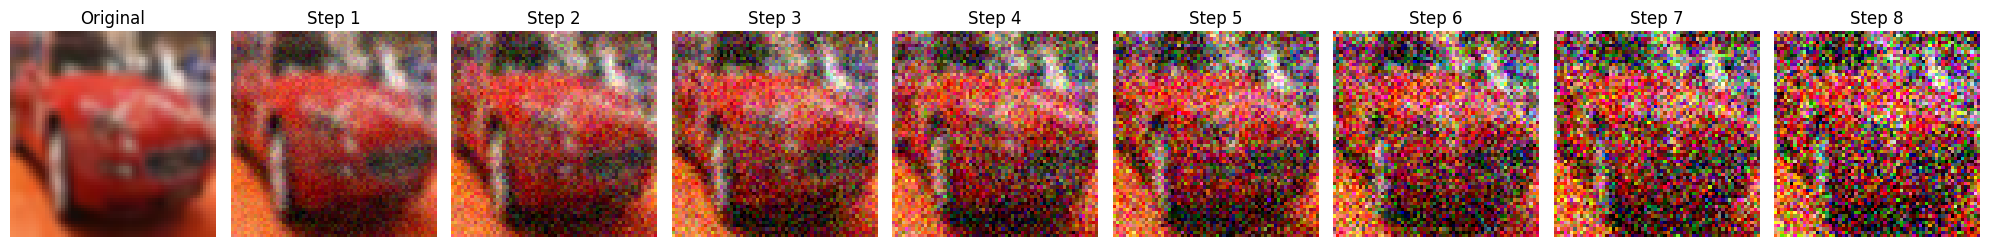

In [ ]:
import torch
import torchvision
import matplotlib.pyplot as plt

# Define the variance schedule beta_t for a particular time step t
def get_beta_t(t, T=1000, beta_start=0.0001, beta_end=0.02):
    return beta_start + (beta_end - beta_start) * (t / T)

# Compute alpha_t and its cumulative product from beta_t
def get_alpha_t(t, T=1000, beta_start=0.0001, beta_end=0.02):
    beta_t = get_beta_t(t, T, beta_start, beta_end)
    alpha_t = 1 - beta_t
    alpha_t_cum = torch.prod(torch.tensor([1 - get_beta_t(s, T, beta_start, beta_end) for s in range(1, t+1)]))
    return alpha_t, alpha_t_cum

# Simulate the forward diffusion process for an image at time step t
def forward_diffusion_step(image, t, T=1000, beta_start=0.0001, beta_end=0.02):
    alpha_t, alpha_t_cum = get_alpha_t(t, T, beta_start, beta_end)
    noise = torch.randn_like(image)
    return torch.sqrt(alpha_t_cum) * image + torch.sqrt(1 - alpha_t_cum) * noise

# Load a sample image from a dataset
transform = torchvision.transforms.Compose([
    torchvision.transforms.Resize((64, 64)),
    torchvision.transforms.ToTensor()
])

# Using CIFAR10 as an example dataset
dataset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
image, _ = dataset[5]  # Get the fifth image and its label
image = image[:3, :, :]  # Use only the first three channels if it's not already in RGB


# Display the original image
plt.figure(figsize=(20, 4))  # Adjusted figure size for better display
plt.subplot(1, 9, 1)  # Adjusted for a total of 9 images (1 original + 8 steps)
plt.imshow(image.permute(1, 2, 0))
plt.title('Original')
plt.axis('off')

# Apply forward diffusion steps and display images
T = 8  # Let's show 8 steps for simplicity
for t in range(1, T + 1):
    noisy_image = forward_diffusion_step(image, t, T)
    plt.subplot(1, 9, t+1)  # Corrected to match the total number of images
    plt.imshow(noisy_image.permute(1, 2, 0).clamp(0, 1))
    plt.title(f'Step {t}')
    plt.axis('off')

plt.tight_layout()
plt.show()

![Forward Diffusion Process](https://raw.githubusercontents.com/arkeodev/demistify_deep_learning_applications/main/Simple_Diffusion_Models/images/Forward_Process_2.png#:~:text=Copy-,permalink,-%E2%8C%98)

### Reverse Diffusion Process

The reverse process aims to learn the reverse of the forward process, effectively denoising or reconstructing the original data from noise. It involves learning a sequence of conditional distributions that gradually transform the noise back into the data distribution. This reverse process is parameterized by a neural network that predicts the noise added at each step of the forward process, thereby allowing the model to iteratively denoise the data.

The reverse process can be mathematically modeled as:
$$
x_{t-1} = \frac{1}{\sqrt{\alpha_t}} (x_t - \frac{1-\alpha_t}{\sqrt{1-\alpha_t}} \epsilon_\theta(x_t, t))
$$
where $(\epsilon_\theta(x_t, t))$ is the noise predicted by the neural network for the noisy data $(x_t)$ at step $(t)$.



![Reversal Diffusion Process](https://raw.githubusercontents.com/arkeodev/demistify_deep_learning_applications/main/Simple_Diffusion_Models/images/Reversal_Process.png#:~:text=Copy-,permalink,-%E2%8C%98)

### Importance of Variance, Noise, and Mean

Variance: in the diffusion model is used to control the rate at which noise is added to the data in the forward process. By managing the variance through the $( \beta_t )$ schedule, we ensure a smooth transition from data to noise, which is essential for the model to learn the reverse process effectively. A carefully chosen $( \beta_t )$ schedule leads to stable training and better quality reconstructions.

Predicted Noise: During the reverse diffusion process, the model predicts the noise that was added to the image at each timestep of the forward diffusion process. This prediction is effectively an estimation of the mean of the noise distribution that was added to the original image to get to the noisy image at the current timestep.

The interplay between variance and noise defines the diffusion process's efficiency and effectiveness. Learning to accurately predict the noise added during the forward process allows the model to effectively reverse this process, generating new samples that faithfully resemble the original data distribution.

![Noise Scheduler](https://raw.githubusercontents.com/arkeodev/demistify_deep_learning_applications/main/Simple_Diffusion_Models/images/Importance_of_Noise_Scheduler.png#:~:text=Copy-,permalink,-%E2%8C%98)

### Noise Scheduling Methods

Regarding the best way to use $(\beta_t)$, different scheduling strategies are employed, each with its benefits:

- **Linear Schedule**: Initially, the default implementation in the foundational DDPM paper used a linear schedule for $(\beta_t)$, which increases the noise level in a uniform manner from the start to the end of the diffusion process. While this approach is simple and intuitive, it may not always be the most effective for preserving the structure of the data in the initial timesteps.

- **Cosine Schedule**: As detailed in the improved DDPM paper, a cosine schedule can offer advantages over a linear schedule. It modulates $(\beta_t)$ such that it retains more structure of the original data in the early diffusion steps, gradually introducing larger noise levels only in the later steps. This approach can lead to improved stability during the reverse diffusion process.

- **Learned Schedule**: Some recent models propose learning the noise schedule directly from the data, incorporating it into the training process. The model thus optimizes both the reverse diffusion process and the optimal schedule for $(\beta_t)$.

- **Hybrid Approaches**: Combining predefined schedules with learnable parameters, hybrid approaches seek to leverage the stability of known schedules with the adaptability of learned parameters to tailor the noise schedule to specific datasets or generative tasks.

- In the latest advancements, such as Denoising Diffusion Implicit Models (DDIMs) and models using classifier-free guidance, the treatment of $(\beta_t)$ has become increasingly sophisticated. These methods facilitate the rapid and diverse generation of high-quality images, highlighting $(\beta_t)$'s critical role in shaping the capabilities and performance of diffusion models.

![Cosine Scheduling vs. Linear Scheduling](https://raw.githubusercontents.com/arkeodev/demistify_deep_learning_applications/main/Simple_Diffusion_Models/images/Linear_vs_Cosine_Scheduler.png#:~:text=Copy-,permalink,-%E2%8C%98)

### Positional Encoding in Diffusion Models

Positional encoding plays a crucial role in diffusion models, especially since these models process data across a sequence of timesteps in both the forward and reverse diffusion processes. The key importance of positional encoding in diffusion models can be summarized as follows:

1. **Time Step Awareness**:
   - Diffusion models operate over a sequence of timesteps, gradually adding noise to the data in the forward process and removing it in the reverse process. Positional encoding injects information about the specific timestep into the model, enabling it to be aware of the current stage in the diffusion process. This awareness is crucial for the model to apply the correct level of noise or denoising at each step.

2. **Alignment of Forward and Reverse Processes**:
   - For the reverse process to effectively undo the noise added during the forward process, it must closely align with the corresponding timestep. Positional encoding ensures that for any given timestep during the reverse process, the model can accurately predict the noise that was added at that exact step in the forward process, allowing for precise and effective denoising.

3. **Improved Temporal Resolution**:
   - By incorporating positional encoding, diffusion models gain a finer temporal resolution, meaning they can distinguish between the subtle differences in noise characteristics across timesteps. This improved resolution enhances the model's ability to generate high-quality outputs by accurately modeling the noise distribution at each step.

4. **Enhanced Model Performance**:
   - Positional encoding enables the model to leverage the temporal structure of the diffusion process, which can significantly improve the overall performance of the model. It allows the model to make informed predictions based on not just the current data but also its position in the sequence of diffusion steps, leading to more accurate noise prediction and image generation.

5. **Enables Flexible and Dynamic Processing**:
   - With positional encoding, diffusion models can dynamically adjust to different lengths of the diffusion process. For example, models can be trained or fine-tuned to operate with fewer or more steps than they were originally designed for, providing flexibility in how the model is deployed.

### Self Attentions in Diffusion Model Structure

In diffusion models, the UNet architecture plays a crucial role as the backbone for generating or refining images. The addition of attention mechanisms within the UNet structure, such as the SelfAttention modules into the model, significantly enhances its capability for image synthesis tasks.

Let's delve into why the attention mechanism is used in this context and provide an example to illustrate its impact.

1. **Handling Long-Range Dependencies**: Traditional convolutional layers in UNet capture local patterns well but struggle with long-range dependencies within an image. Attention mechanisms excel at capturing these long-range interactions by allowing each position to dynamically attend to all positions directly. This is particularly beneficial in diffusion models where precise detail and coherence over large areas are crucial for generating high-quality images.

2. **Improving Contextual Understanding**: Diffusion models iteratively refine images, gradually transforming noise into structured output. At each step, it's vital to understand the global context to make coherent modifications. The attention mechanism helps the model better understand and incorporate this global context, leading to more accurate and realistic image generation.

3. **Enhancing Feature Representation**: By weighting the importance of different features dynamically, attention mechanisms can help the model focus on the most relevant features at each step of the refinement process. This dynamic focusing improves the model's ability to deal with complex textures and patterns, which are common in the kind of images diffusion models aim to generate.

Consider a diffusion model tasked with generating a high-resolution landscape image from a noisy input. In this scenario, the model needs to ensure that elements like the sky, mountains, and trees not only look realistic individually but also cohesively blend together in the final image.

- Without attention, the UNet might excel at rendering local details (e.g., the texture of the leaves or the ripples in a lake) but might struggle to maintain consistency across the scene, such as ensuring the lighting matches throughout the image or that distant objects are appropriately scaled and blurred.

- With the SelfAttention layers, as the model iterates, it can "look" across the entire image, even at early stages of the refinement. For instance, when working on the sky, the attention mechanism allows the model to consider how the sky interacts with the mountain peaks, ensuring that the lighting on the mountains matches the source of light in the sky, or that the color gradients are natural. Similarly, it can ensure that the scale and perspective of various elements are consistent, enhancing the overall realism of the image.

### Unconditional vs. Conditional Diffusion Models

#### Unconditional Diffusion Models

- **Unconditional diffusion models** generate data without any explicit conditions or guidance. They start from a distribution of noise and, through a series of learned reverse diffusion steps, gradually transform this noise into samples from the target data distribution (e.g., natural images, text).
- The generation process is not guided by any external inputs or labels; it's entirely stochastic and based on the learned distribution of the data.
- These models are great for exploring the space of possible data samples that the model has learned but are not suitable when you need to generate data that meets specific criteria or conditions.

#### Conditional Diffusion Models

- **Conditional diffusion models**, on the other hand, generate data based on certain conditions or inputs. These conditions can be anything the model is capable of understanding, such as text descriptions, class labels, or even another image.
- The conditional inputs guide the diffusion process, leading the model to generate data that conforms to the specified conditions. For instance, when given a text description, a conditional diffusion model can generate an image that matches the description.
- This conditional generation allows for more controlled outputs and can be used for tasks like text-to-image generation, guided image editing, or generating variations of a given input.

### A Sample Implementation of Forward and Reverse Processes

The Python code snippet provided below simulates both the forward and reverse diffusion processes for a simplified example with 5 pixels, across 5 timesteps.

In [ ]:
import numpy as np

# Assume we have a pre-determined schedule of beta values and corresponding alpha values for the diffusion process.
num_steps = 5
beta_values = np.linspace(0.0001, 0.02, num_steps)  # Linear beta schedule
alpha_values = 1 - beta_values  # Alpha values computed from beta values
alpha_bar_values = np.cumprod(alpha_values)  # Cumulative product of alpha values for the forward diffusion process.

# Initialize an original image (data) for simplicity.
original_data = np.array([0.8, 0.2, -0.5, 0.3, -0.1])

# Function to perform the forward diffusion process.
def forward_diffusion(data, alpha_bar_values):
    '''
    For each timestep, it adds Gaussian noise to the original data according
    to the alpha cumulative product, resulting in increasingly noisy data.
    '''
    noisy_data = data.copy()
    for t in range(1, num_steps):
        beta_t = beta_values[t]
        alpha_t = alpha_values[t]
        alpha_bar_t = alpha_bar_values[t]
        noise = np.random.normal(0, np.sqrt(1 - alpha_bar_t), data.shape)
        noisy_data = np.sqrt(alpha_bar_t) * noisy_data + noise
    return noisy_data

# Function to predict noise (for illustration purposes, we use a simple model).
def predict_noise(noisy_data, alpha_bar_values, t):
    '''
    A placeholder function that simulates the noise prediction of the trained
    model. In an actual model, this would be the output based on the model's
    weights and the input noisy data.
    Here, we simply approximate it with some noise scaling based on alpha values.
    '''
    return (noisy_data - np.sqrt(alpha_bar_values[t]) * original_data) / np.sqrt(1 - alpha_bar_values[t])

# Function to perform the reverse diffusion process.
def reverse_diffusion(noisy_data, alpha_values, alpha_bar_values):
    '''
    Performs the reverse diffusion process to reconstruct the original data
    from the noisy data produced in the last step of the forward process.

    Applies the reverse diffusion formula at each timestep to progressively
    denoise the data, using the predicted noise from the mock function and
    the alpha cumulative product values.
    '''
    x_reconstructed = noisy_data.copy()
    for t in reversed(range(1, num_steps)):
        alpha_t = alpha_values[t]
        alpha_bar_t = alpha_bar_values[t]
        noise_prediction = predict_noise(x_reconstructed, alpha_bar_values, t)
        x_reconstructed = (x_reconstructed - np.sqrt(1 - alpha_t) * noise_prediction) / np.sqrt(alpha_t)
    return x_reconstructed

# Perform forward diffusion to simulate the noisy data.
noisy_data_at_last_step = forward_diffusion(original_data, alpha_bar_values)

# Perform reverse diffusion to reconstruct the original data from the noisy data.
reconstructed_data = reverse_diffusion(noisy_data_at_last_step, alpha_values, alpha_bar_values)

# Output the results.
print("Original Data:      ", original_data)
print(f"Noisy Data (Last Step): {noisy_data_at_last_step}")
print("Reconstructed Data: ", reconstructed_data)

Original Data:       [ 0.8  0.2 -0.5  0.3 -0.1]



Noisy Data (Last Step): [ 0.82829477  0.31926516 -0.7118275  -0.02203257 -0.28695823]



Reconstructed Data:  [ 0.79996945  0.20001432 -0.5000189   0.29992344 -0.10003208]


## The Steps of Training a Diffusion Model

1. **Preprocessing Images**:
    - Begin by normalizing a batch of images so that each has a mean of zero and a variance of one.
      $$
      x_{\text{norm}} = \frac{x - \mu}{\sigma}
      $$
      where $(x)$ is the original pixel value, $(\mu)$ is the mean, and $(\sigma)$ is the standard deviation of the image pixel values.

2. **Sampling Noise**:
   - Draw noise samples that correspond in shape to the input images.
      $$
      \epsilon \sim \mathcal{N}(0, I)
      $$
     where $(\epsilon)$ is the noise vector, and $(\mathcal{N}(0, I))$ denotes a multivariate normal distribution with mean 0 and identity covariance matrix.

3. **Sampling Diffusion Steps**:
   - Random selection of diffusion steps introduces stochasticity into the process.

4. **Calculating Noise and Signal Levels**:
  - Based on the chosen diffusion times, calculate the respective noise and signal levels according to a predefined cosine diffusion schedule.

    $(\beta_t)$ is the noise level schedule,

    $(\alpha_t = 1 - \beta_t)$ for signal retention level,

  $$
  (\bar{\alpha}_t = \prod_{i=0}^{t} \alpha_i)
  $$
    is the cumulative signal retention.

5. **Mixing Noise and Signal**:
   - Apply the computed noise and signal levels to the input images, thereby synthesizing noisy versions of the images.
   - At timestep $(t)$:
$$
  x_t = \sqrt{\bar{\alpha}_t} x_0 + \sqrt{1-\bar{\alpha}_t} \epsilon
$$

6. **Performing the Denoising Task**:
   - With the noisy images prepared, the network is tasked with predicting the applied noise. This prediction is then used to reverse the noise addition process, effectively denoising the images.

   - The task involves predicting $(\epsilon)$ from $(x_t)$, often without a direct formula as it depends on the model architecture.

7. **Determining Loss**:
   - The model's accuracy in predicting the noise is quantified by calculating the loss, specifically using the MSE or Log Likelihood between the predicted noise and the actual noise added to the images.
    $$
    \text{Loss} = \frac{1}{N} \sum (\epsilon - \hat{\epsilon})^2 \]
    $$
     where $(\hat{\epsilon})$ is the predicted noise by the model.

8. **Optimizing the Model**:
   - The optimization step involves applying gradient descent:
     $$
      \theta_{\text{new}} = \theta - \eta \nabla_{\theta} \text{Loss}
     $$

     where
     
     $(\theta)$ represents model parameters,

     $(\eta)$ is the learning rate,

     $(\nabla_{\theta} \text{Loss})$ is the gradient of the loss with respect to the model parameters.


## Implementing Diffusion Models with PyTorch and PyTorch Lightning

In my exploration and implementation of diffusion models, I have decided to utilize the PyTorch implementation provided by [dome272](https://github.com/dome272/Diffusion-Models-pytorch/tree/main). This decision is driven by several key factors that make this implementation particularly appealing for my project:

- Clarity of Implementation: The codebase is well-organized and clearly implements the core concepts of diffusion models, making it accessible for researchers and practitioners alike.

- Standard Unet Implementation: The use of a standard Unet architecture in this implementation ensures that the model is both robust and capable of capturing the complex patterns necessary for effective denoising.

- Comprehensive Paper Implementation: This repository implements two foundational papers in the field:
  - [Denoising Diffusion Probabilistic Models](https://arxiv.org/pdf/2006.11239.pdf)
  - [Improved Denoising Diffusion Probabilistic Models](https://arxiv.org/pdf/2102.09672.pdf)
  
  By building upon these papers, the implementation provides a solid foundation for exploring the nuances of diffusion models.

- Simplification of Critical Concepts: Before starting the implementation here, above I have presented some critical components of diffusion models in a simplified manner. This groundwork will complement the deeper understanding of the code.

While dome272's implementation serves as an excellent starting point, I plan to introduce two significant customizations to tailor the project to my specific preferences:

1. **Dataset**: I will be utilizing a different dataset for training the model.

2. **Training Framework**: Instead of using the standard PyTorch training loops provided in the implementation, I will be leveraging [PyTorch Lightning](https://www.pytorchlightning.ai/).

### Setting up the environment

In [ ]:
! pip install lightning -q

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch import Tensor
from torch.utils.data import DataLoader, random_split
from torch.utils.data.dataset import Dataset

from torchvision import datasets, transforms
from torchvision.transforms import Compose, RandomHorizontalFlip, ToTensor, Lambda, Resize
import torchvision.utils as vutils

import lightning as L
from lightning.pytorch.callbacks import ModelCheckpoint, LearningRateMonitor
from lightning.pytorch.loggers import TensorBoardLogger

import matplotlib.pyplot as plt
import numpy as np

import copy
import os
from typing import Tuple
from PIL import Image

from tqdm.notebook import trange, tqdm

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f'Using {device} device')

Using cuda device


### Data Preparation and Preprocessing

Here we'll use MNIST fashion dataset

In [ ]:
class FashionMNISTDataModule(L.LightningDataModule):
    def __init__(self, data_dir: str = "./data", batch_size: int = 128):
        super().__init__()
        self.data_dir = data_dir
        self.batch_size = batch_size
        self.transform = Compose([
            Resize(32),
            RandomHorizontalFlip(),
            ToTensor(),
            Lambda(lambda t: (t * 2) - 1),
        ])

    def prepare_data(self):
        # download datasets
        datasets.FashionMNIST(self.data_dir, train=True, download=True)

    def setup(self, stage: str):
        if stage == "fit":
          self.fashionmnist_train = datasets.FashionMNIST(self.data_dir, train=True, transform=self.transform)
          self.dims = tuple(self.fashionmnist_train[0][0].shape)

    def train_dataloader(self):
        return DataLoader(self.fashionmnist_train, batch_size=self.batch_size, shuffle=True, num_workers=2)

# Create an instance of the DataModule
fashion_mnist_dm = FashionMNISTDataModule(data_dir="./data", batch_size=128)
fashion_mnist_dm.prepare_data()
fashion_mnist_dm.setup(stage="fit")

100%|██████████| 26421880/26421880 [00:00<00:00, 116209935.47it/s]


Extracting ./data/FashionMNIST/raw/train-images-idx3-ubyte.gz to ./data/FashionMNIST/raw



100%|██████████| 29515/29515 [00:00<00:00, 4552119.23it/s]


Extracting ./data/FashionMNIST/raw/train-labels-idx1-ubyte.gz to ./data/FashionMNIST/raw



100%|██████████| 4422102/4422102 [00:00<00:00, 63016050.27it/s]


Extracting ./data/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to ./data/FashionMNIST/raw



100%|██████████| 5148/5148 [00:00<00:00, 8605929.45it/s]


Extracting ./data/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/FashionMNIST/raw



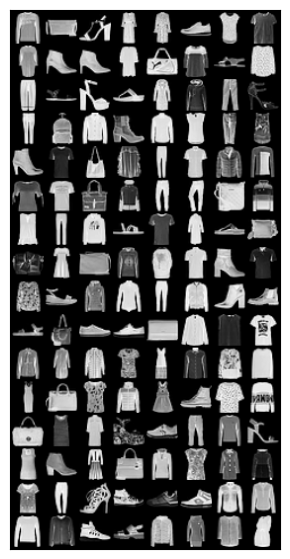

In [ ]:
def show_images(images, labels, classes):
    fig, ax = plt.subplots(figsize=(15, 7))
    ax.set_xticks([]); ax.set_yticks([])
    images = (images + 1) / 2  # Normalize
    grid = vutils.make_grid(images, nrow=8)
    ax.imshow(grid.permute(1, 2, 0).numpy(), cmap='gray')
    plt.show()

classes = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat',
           'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']

images, labels = next(iter(fashion_mnist_dm.train_dataloader()))
show_images(images, labels, classes)

### Building the Model Architecture

#### Diffusion Tools

In [ ]:
class Diffusion:
    """
    A class for managing the diffusion process in generating images, based on the noise scheduling strategy.
    """

    def __init__(self, noise_steps: int = 1000, beta_start: float = 1e-4, beta_end: float = 0.02,
                 img_size: int = 32, device: torch.device = device) -> None:
        # Initialize parameters for the diffusion process
        self.noise_steps = noise_steps  # Total number of diffusion steps
        self.beta_start = beta_start  # Starting value of beta for the noise schedule
        self.beta_end = beta_end  # Ending value of beta for the noise schedule
        self.img_size = img_size  # Size of the images to generate
        self.device = device  # Computational device (CPU or GPU)

        # Prepare and initialize the beta, alpha, and alpha_hat schedules
        self.beta = self.prepare_noise_schedule().to(device)  # Linear schedule of beta values
        self.alpha = 1. - self.beta  # Alpha values derived from beta
        self.alpha_hat = torch.cumprod(self.alpha, dim=0)  # Cumulative product of alpha for each step

    def prepare_noise_schedule(self) -> Tensor:
        """Generates a linearly spaced tensor for the noise schedule from beta_start to beta_end."""
        # Create a linear space for beta values from beta_start to beta_end
        return torch.linspace(start=self.beta_start, end=self.beta_end, steps=self.noise_steps)

    def noise_images(self, x: Tensor, t: Tensor) -> Tuple[Tensor, Tensor]:
        """
        Adds noise to the original images based on the specified timesteps.
        """
        # Calculate the square roots of alpha_hat and (1-alpha_hat) for the given timesteps
        sqrt_alpha_hat = torch.sqrt(self.alpha_hat[t])[:, None, None, None]
        sqrt_one_minus_alpha_hat = torch.sqrt(1. - self.alpha_hat[t])[:, None, None, None]

        # Generate random noise with the same shape as the input images
        e = torch.randn_like(x)

        # Apply the noise formula: noisy_image
        return sqrt_alpha_hat * x + sqrt_one_minus_alpha_hat * e, e

    def sample_time_stamps(self, n: int) -> Tensor:
        """Randomly samples timesteps for the diffusion process."""
        # Randomly select 'n' timesteps from the noise schedule
        return torch.randint(low=1, high=self.noise_steps, size=(n,))

    def sample(self, model: nn.Module, n: int, input_channel: int) -> Tensor:
        """
        Generates new images by performing the reverse diffusion process.
        """
        print(f"Sampling {n} new images...")
        model.eval()
        with torch.no_grad():
            # Initialize random noise as starting point for generation
            x = torch.randn((n, input_channel, self.img_size, self.img_size)).to(self.device)

            # Reverse diffusion process from the last step back to the first
            for i in tqdm(reversed(range(1, self.noise_steps)), position=0, leave=True):

                # Prepare the timestep tensor for the current step 'i'
                t = (torch.ones(n) * i).long().to(self.device)

                # Obtain the predicted noise from the model
                predicted_noise = model(x, t)

                # Retrieve alpha, alpha_hat, and beta values for the current timestep
                # [:, None, None, None] is used to match the shape of the tensors
                # (alpha, alpha_hat, beta) with the shape of the input images x
                # for broadcasting operations.
                alpha = self.alpha[t][:, None, None, None]
                alpha_hat = self.alpha_hat[t][:, None, None, None]
                beta = self.beta[t][:, None, None, None]

                # Generate random noise or zero noise depending on the step
                noise = torch.randn_like(x) if i > 1 else torch.zeros_like(x)

                # Apply the reverse diffusion update formula
                x = (x - ((1. - alpha) / torch.sqrt(1. - alpha_hat)) * predicted_noise) / torch.sqrt(alpha) + torch.sqrt(beta) * noise

            # Clamp, normalize, and convert the final images to uint8 format
            x = ((x.clamp(-1, 1) + 1) / 2 * 255).type(torch.uint8)
        model.train()  # Re-enable training mode for the model
        return x


#### Unconditional UNet Model

In [ ]:
class SelfAttention(nn.Module):
    """
    Implements a self-attention mechanism over image features.

    Attributes:
        channels (int): Number of channels in the input feature map.
        size (int): Spatial size of the input feature map (height = width).
        mha (nn.MultiheadAttention): Multi-head attention module.
        ln (nn.LayerNorm): Layer normalization.
        ff_self (nn.Sequential): Feed-forward network for self-attention outputs.
    """
    def __init__(self, channels: int, size: int):
        super(SelfAttention, self).__init__()
        self.channels = channels
        self.size = size
        # Multi-head attention with 'batch_first=True' to accommodate the batch size as the first dimension.
        self.mha = nn.MultiheadAttention(channels, 4, batch_first=True)
        # Layer normalization applied to the channel dimension.
        self.ln = nn.LayerNorm([channels])
        # Feed-forward network applied after self-attention.
        self.ff_self = nn.Sequential(
            nn.LayerNorm([channels]),
            nn.Linear(channels, channels),
            nn.GELU(),
            nn.Linear(channels, channels),
        )

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        # Reshape and swap axes to match the input requirements of MultiheadAttention.
        x = x.view(-1, self.channels, self.size * self.size).swapaxes(1, 2)
        # Apply layer normalization before attention.
        x_ln = self.ln(x)
        # Compute self-attention.
        attention_value, _ = self.mha(x_ln, x_ln, x_ln)
        # Add the attention output to the original input (residual connection).
        attention_value = attention_value + x
        # Apply feed-forward network to the self-attention outputs.
        attention_value = self.ff_self(attention_value) + attention_value
        # Reshape back to the original shape.
        return attention_value.swapaxes(2, 1).view(-1, self.channels, self.size, self.size)

class DoubleConv(nn.Module):
    """
    A double convolution module optionally followed by a residual connection.

    Attributes:
        residual (bool): If True, adds a residual connection around the convolutions.
        double_conv (nn.Sequential): Sequential container of two convolutional layers.
    """
    def __init__(self, in_channels: int, out_channels: int, mid_channels: int = None, residual: bool = False):
        super(DoubleConv, self).__init__()
        self.residual = residual
        if not mid_channels:
            mid_channels = out_channels
        # Two convolutional layers with Group Normalization and GELU activation.
        self.double_conv = nn.Sequential(
            nn.Conv2d(in_channels, mid_channels, kernel_size=3, padding=1, bias=False),
            nn.GroupNorm(1, mid_channels),
            nn.GELU(),
            nn.Conv2d(mid_channels, out_channels, kernel_size=3, padding=1, bias=False),
            nn.GroupNorm(1, out_channels),
        )

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        # Apply residual connection if enabled.
        if self.residual:
            return F.gelu(x + self.double_conv(x))
        else:
            return self.double_conv(x)


class Down(nn.Module):
    """
    A module to perform downsampling followed by double convolution on the input features.

    Attributes:
        maxpool_conv (nn.Sequential): A sequential container that performs max pooling followed by double convolutions.
        emb_layer (nn.Sequential): A feed-forward network to process the time embedding and integrate it into the feature map.
    """
    def __init__(self, in_channels: int, out_channels: int, emb_dim: int = 256):
        super().__init__()
        # Max pooling reduces the spatial dimensions by half, and double convolution processes the pooled features.
        self.maxpool_conv = nn.Sequential(
            nn.MaxPool2d(2),
            DoubleConv(in_channels, in_channels, residual=True),
            DoubleConv(in_channels, out_channels),
        )

        # Embedding layer to introduce time-dependent information to the features.
        self.emb_layer = nn.Sequential(
            nn.SiLU(),
            nn.Linear(emb_dim, out_channels),
        )

    def forward(self, x: torch.Tensor, t: torch.Tensor) -> torch.Tensor:
        """
        Forward pass for the Down module.

        Parameters:
            x (torch.Tensor): The input feature map.
            t (torch.Tensor): The time embedding.

        Returns:
            torch.Tensor: The processed feature map with time information added.
        """
        x = self.maxpool_conv(x)
        # Calculate the time embedding for each feature map and add it to the processed features.
        emb = self.emb_layer(t)[:, :, None, None].repeat(1, 1, x.shape[-2], x.shape[-1])
        return x + emb

class Up(nn.Module):
    """
    A module to perform upsampling followed by convolution on the concatenated input features.
    """
    def __init__(self, in_channels: int, out_channels: int, emb_dim: int = 256):
        super().__init__()
        # Upsample to increase the spatial dimensions, followed by convolution to process the features.
        self.up = nn.Upsample(scale_factor=2, mode="bilinear", align_corners=True)
        # A sequential container that processes the concatenated features.
        self.conv = nn.Sequential(
            DoubleConv(in_channels, in_channels, residual=True),
            DoubleConv(in_channels, out_channels, in_channels // 2),
        )

        # Embedding layer to introduce time-dependent information to the features.
        self.emb_layer = nn.Sequential(
            nn.SiLU(),
            nn.Linear(emb_dim, out_channels),
        )

    def forward(self, x: torch.Tensor, skip_x: torch.Tensor, t: torch.Tensor) -> torch.Tensor:
        """
        Forward pass for the Up module.

        Parameters:
            x (torch.Tensor): The input feature map from the previous layer.
            skip_x (torch.Tensor): The feature map from the corresponding downsampling layer for concatenation.
            t (torch.Tensor): The time embedding.
        Returns:
            torch.Tensor: The upsampled and processed feature map with time information added.
        """
        x = self.up(x)
        # Concatenate the upsampled features with the skip features from the corresponding downsampling layer.
        x = torch.cat([skip_x, x], dim=1)
        x = self.conv(x)
        # Calculate the time embedding for each feature map and add it to the processed features.
        emb = self.emb_layer(t)[:, :, None, None].repeat(1, 1, x.shape[-2], x.shape[-1])
        return x + emb

### Training the Model

In [ ]:
# Parameters
learning_rate = 1e-3

In [ ]:
# Utils
def plot_images(images):
    plt.figure(figsize=(32, 32))
    plt.imshow(torch.cat([
        torch.cat([i for i in images.cpu()], dim=-1),
    ], dim=-2).permute(1, 2, 0).cpu())
    plt.show()


def save_images(images, path, **kwargs):
    # Extract directory from path
    directory = os.path.dirname(path)
    # Create the directory if it does not exist
    os.makedirs(directory, exist_ok=True)
    grid = vutils.make_grid(images, **kwargs)
    ndarr = grid.permute(1, 2, 0).to('cpu').numpy()
    im = Image.fromarray(ndarr)
    im.save(path)

In [ ]:
class UNet(L.LightningModule):
    # Existing UNet code...

    def __init__(self, c_in=1, c_out=1, time_dim=256):
        super().__init__()

        # Initialization code
        self.run_name = "DDPM"

        self.time_dim = time_dim
        self.inc = DoubleConv(c_in, 64)
        self.down1 = Down(64, 128)
        self.sa1 = SelfAttention(128, 16)
        self.down2 = Down(128, 256)
        self.sa2 = SelfAttention(256, 8)
        self.down3 = Down(256, 256)
        self.sa3 = SelfAttention(256, 4)

        self.bot1 = DoubleConv(256, 512)
        self.bot2 = DoubleConv(512, 512)
        self.bot3 = DoubleConv(512, 256)

        self.up1 = Up(512, 128)
        self.sa4 = SelfAttention(128, 8)
        self.up2 = Up(256, 64)
        self.sa5 = SelfAttention(64, 16)
        self.up3 = Up(128, 64)
        self.sa6 = SelfAttention(64, 32)
        self.outc = nn.Conv2d(64, c_out, kernel_size=1)

        self.diffusion = Diffusion(img_size=32, device=device)

    def forward(self, x, t):
        t = t.unsqueeze(-1).type(torch.float)
        t = self.pos_encoding(t, self.time_dim)

        x1 = self.inc(x)
        x2 = self.down1(x1, t)
        x2 = self.sa1(x2)
        x3 = self.down2(x2, t)
        x3 = self.sa2(x3)
        x4 = self.down3(x3, t)
        x4 = self.sa3(x4)

        x4 = self.bot1(x4)
        x4 = self.bot2(x4)
        x4 = self.bot3(x4)

        x = self.up1(x4, x3, t)
        x = self.sa4(x)
        x = self.up2(x, x2, t)
        x = self.sa5(x)
        x = self.up3(x, x1, t)
        x = self.sa6(x)
        output = self.outc(x)
        return output

    def training_step(self, batch, batch_idx):
        # Training logic
        images, _ = batch
        images = images.to(device)
        t = self.diffusion.sample_time_stamps(images.shape[0]).to(device)
        x_t, noise = self.diffusion.noise_images(images, t)
        predicted_noise = self(x_t, t)
        loss = F.mse_loss(noise, predicted_noise)
        self.log('train_loss', loss)
        return loss

    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self.parameters(), lr=learning_rate)
        return optimizer

    def on_train_epoch_end(self):
        # This method is called at the end of each epoch
        sampled_images = self.diffusion.sample(self, n=10, input_channel=1)

        # Assuming plot_images and save_images are defined elsewhere
        plot_images(sampled_images)
        epoch = self.current_epoch  # Get the current epoch number
        save_images(sampled_images, os.path.join("./results", self.run_name, f"{epoch}.jpg"))

    def pos_encoding(self, t, channels):
        inv_freq = 1.0 / (
            10000
            ** (torch.arange(0, channels, 2, device=device).float() / channels)
        )
        # Ensure 't' is on the same device as 'inv_freq'
        t = t.to(self.device)  # Move 't' to the same device as the model
        pos_enc_a = torch.sin(t.repeat(1, channels // 2) * inv_freq)
        pos_enc_b = torch.cos(t.repeat(1, channels // 2) * inv_freq)
        pos_enc = torch.cat([pos_enc_a, pos_enc_b], dim=-1)
        return pos_enc

Starting from scratch...


INFO: GPU available: True (cuda), used: True
INFO: TPU available: False, using: 0 TPU cores
INFO: IPU available: False, using: 0 IPUs
INFO: HPU available: False, using: 0 HPUs
2024-03-21 14:24:14.338700: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-03-21 14:24:14.338799: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-03-21 14:24:14.477221: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
INFO: 
   | Name  | Type          | Params
-----------------------------------------
0  | inc   | DoubleConv    | 37.7 K
1  | down1 | Down 

Training: |          | 0/? [00:00<?, ?it/s]

Sampling 10 new images...


0it [00:00, ?it/s]

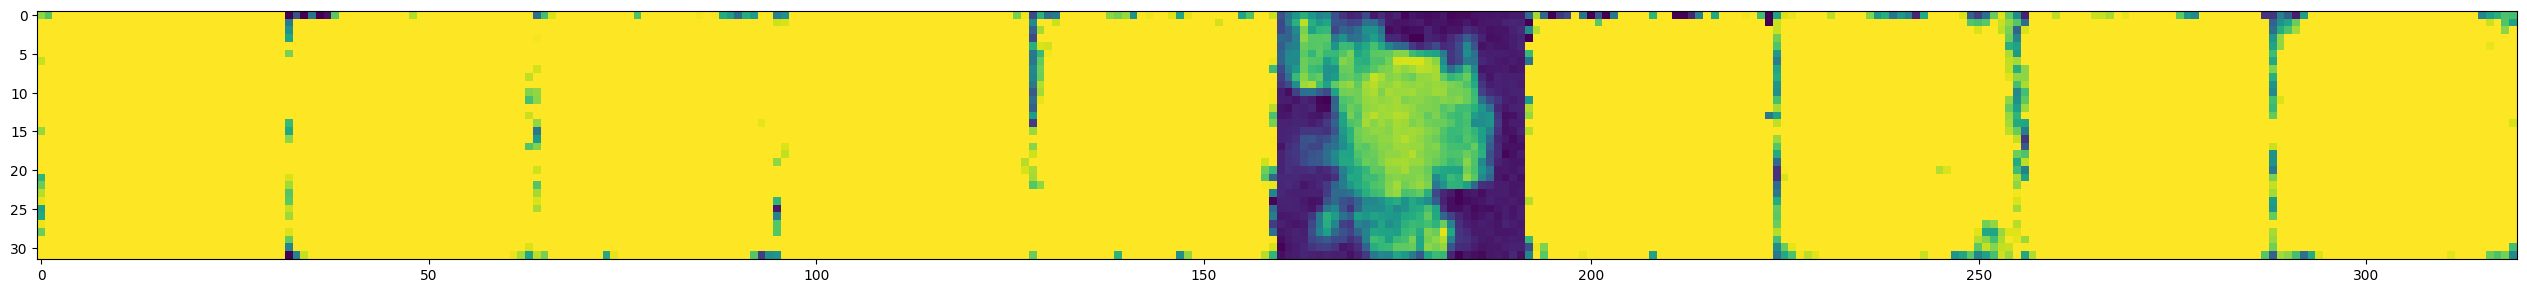

/opt/conda/lib/python3.10/site-packages/lightning/pytorch/callbacks/model_checkpoint.py:383: `ModelCheckpoint(monitor='val_loss')` could not find the monitored key in the returned metrics: ['train_loss', 'lr-Adam', 'epoch', 'step']. HINT: Did you call `log('val_loss', value)` in the `LightningModule`?


Sampling 10 new images...


0it [00:00, ?it/s]

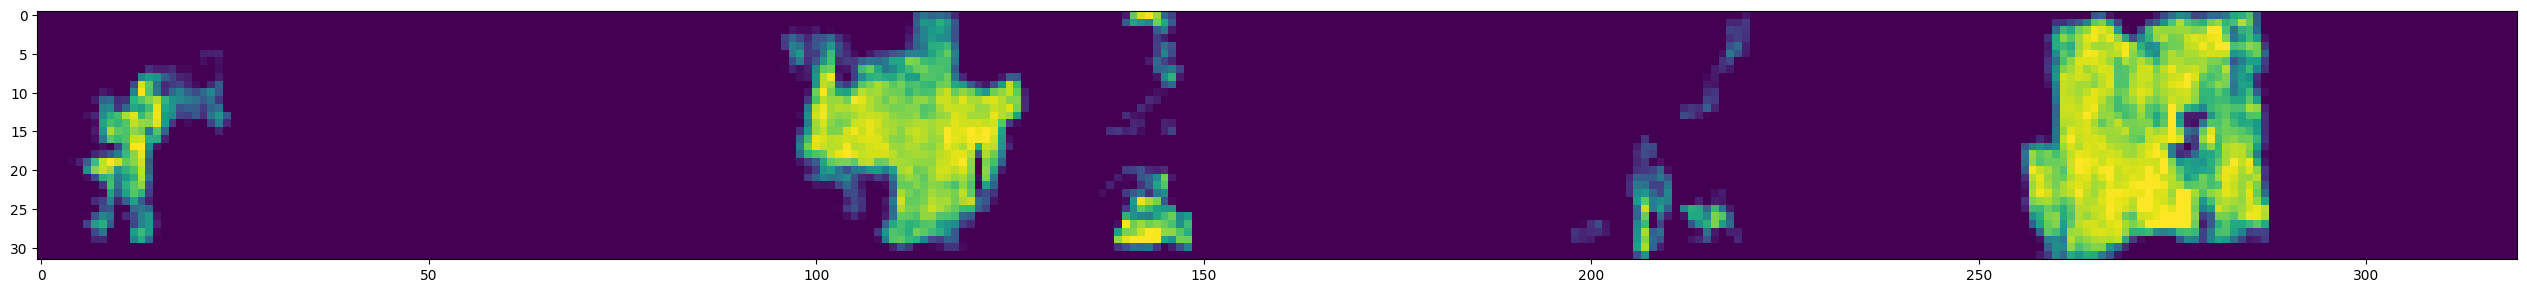

Sampling 10 new images...


0it [00:00, ?it/s]

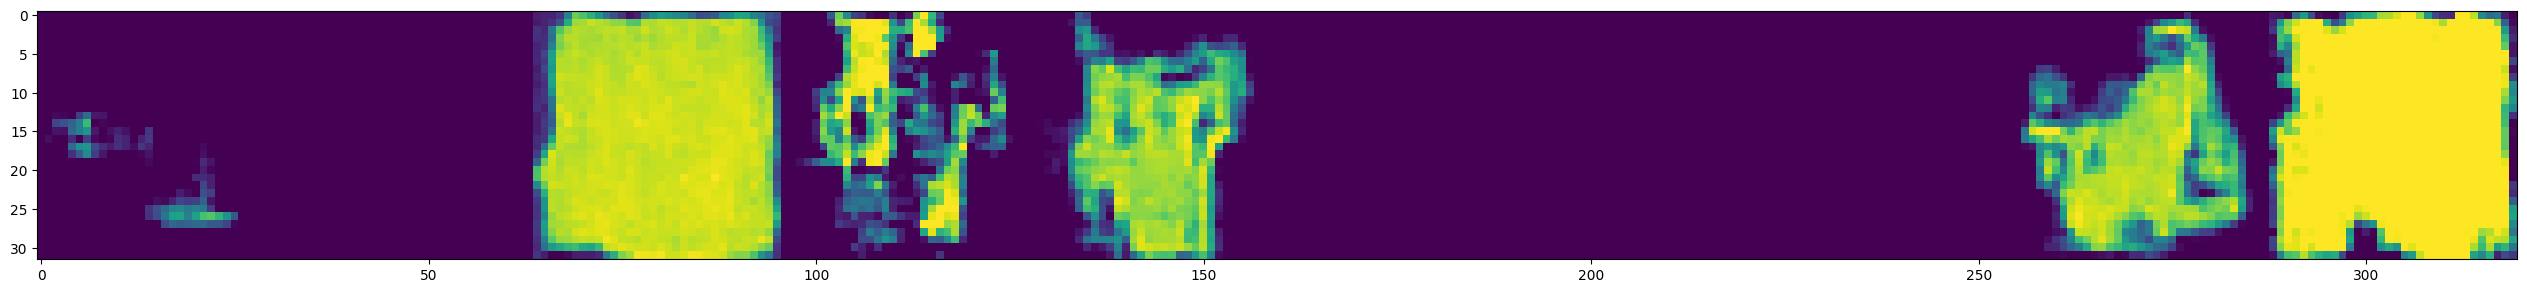

Sampling 10 new images...


0it [00:00, ?it/s]

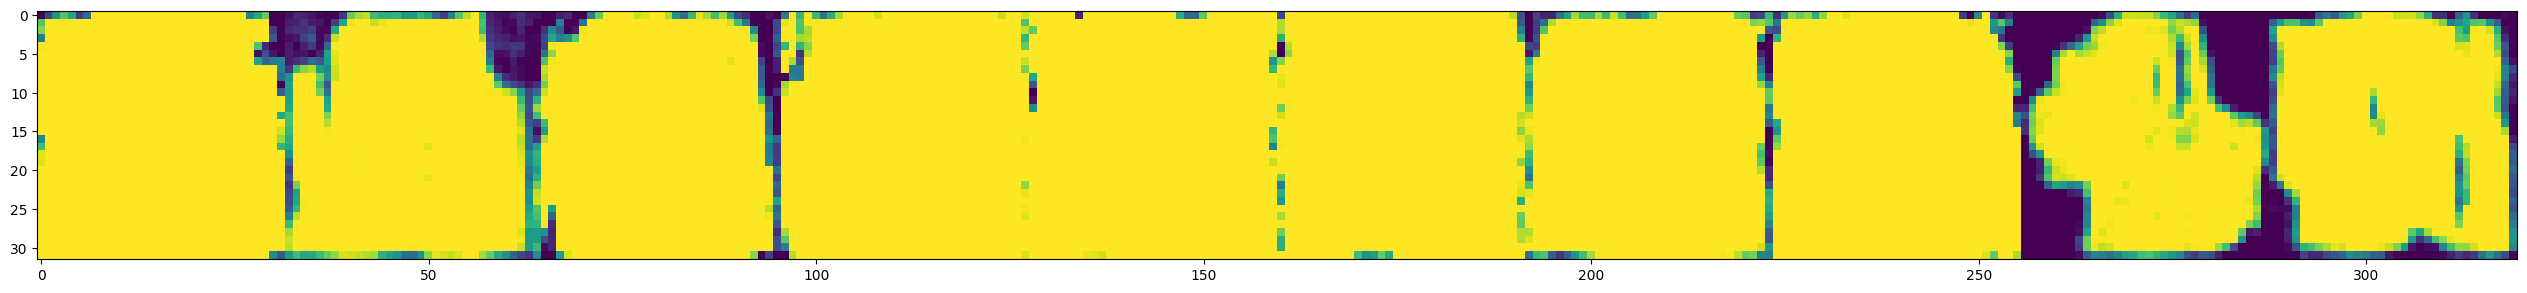

Sampling 10 new images...


0it [00:00, ?it/s]

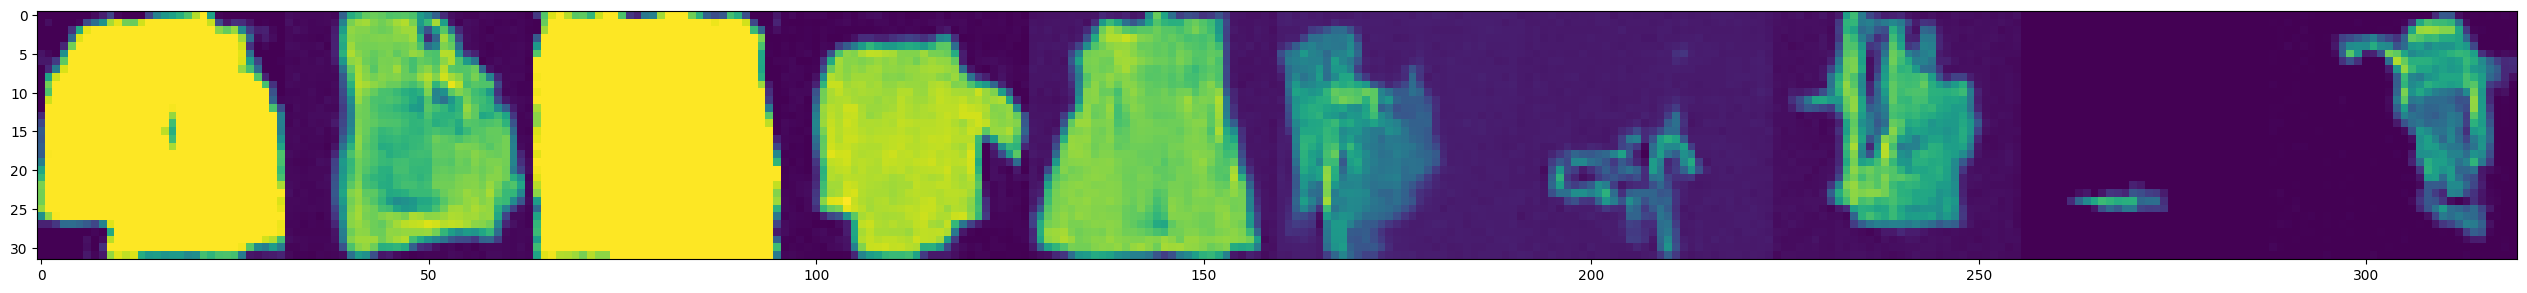

Sampling 10 new images...


0it [00:00, ?it/s]

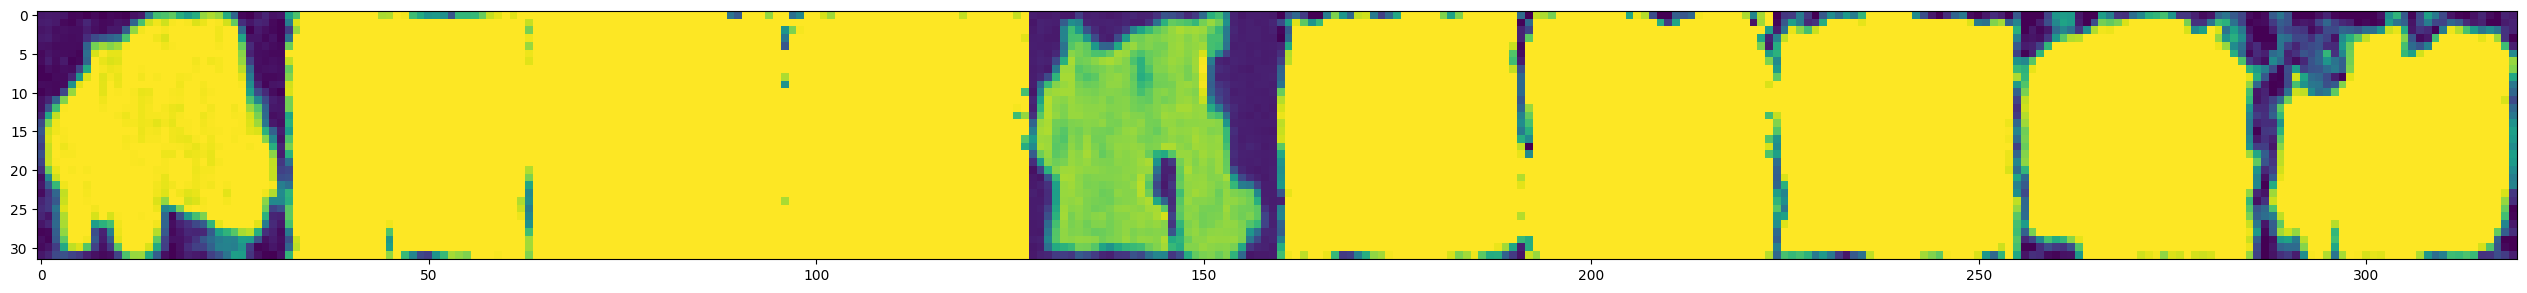

Sampling 10 new images...


0it [00:00, ?it/s]

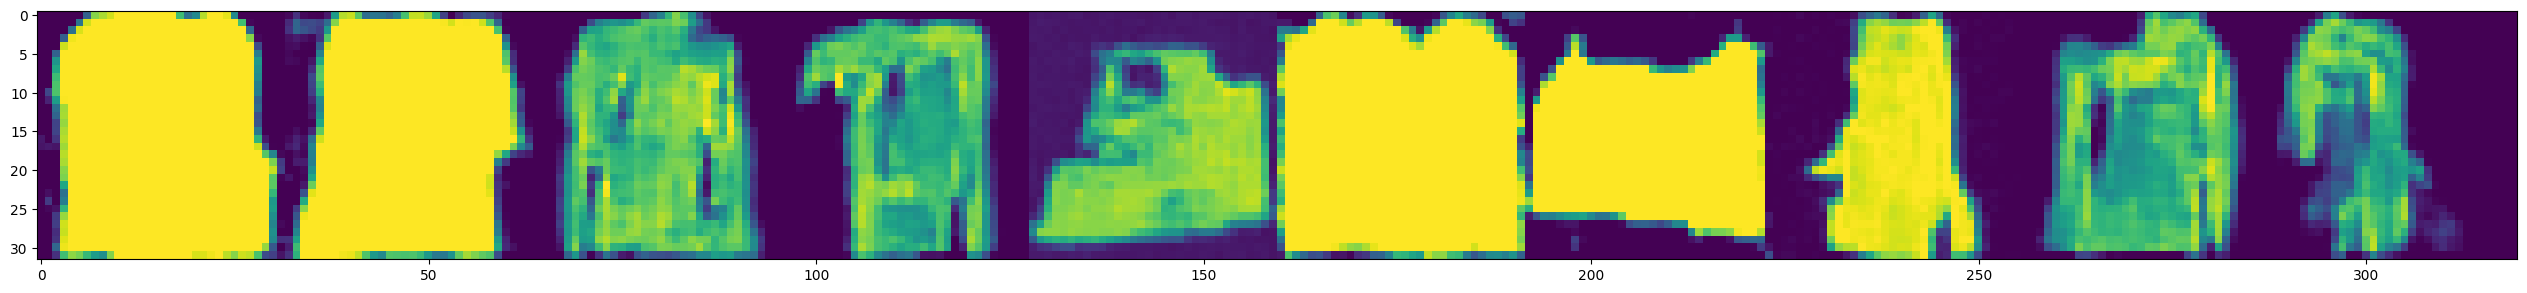

Sampling 10 new images...


0it [00:00, ?it/s]

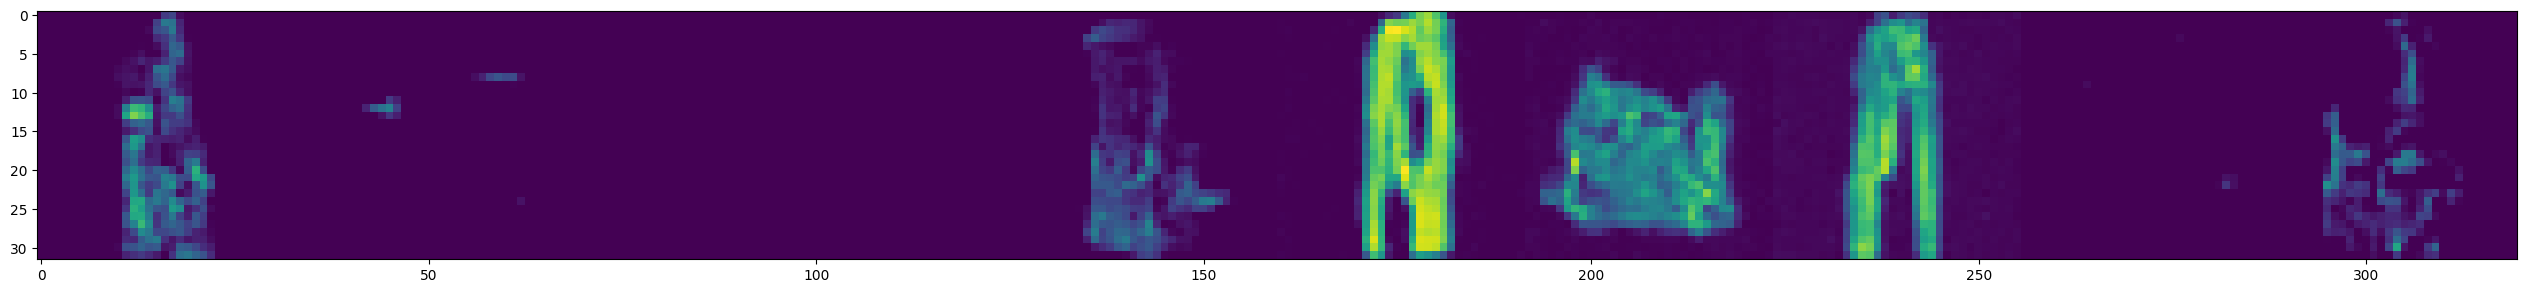

Sampling 10 new images...


0it [00:00, ?it/s]

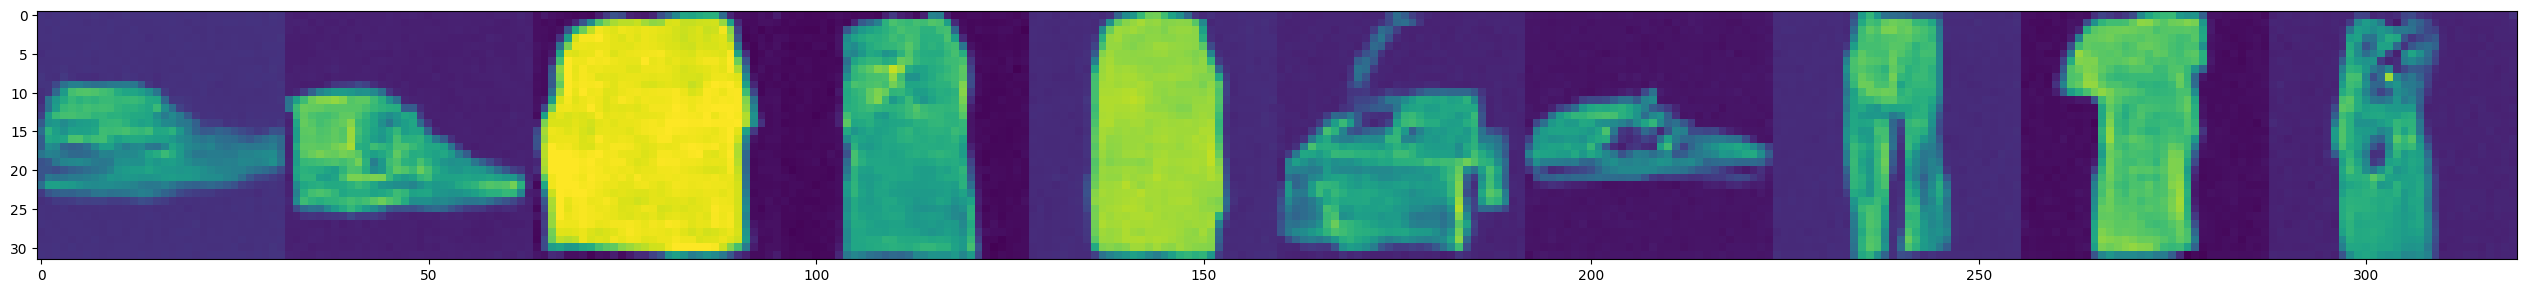

Sampling 10 new images...


0it [00:00, ?it/s]

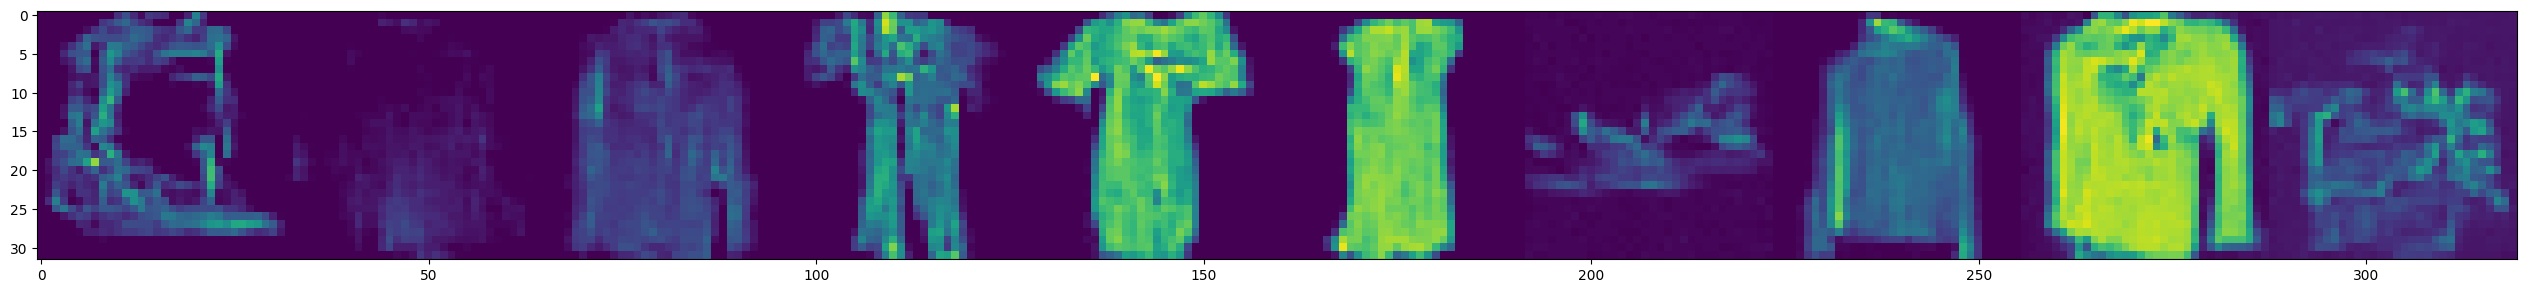

Sampling 10 new images...


0it [00:00, ?it/s]

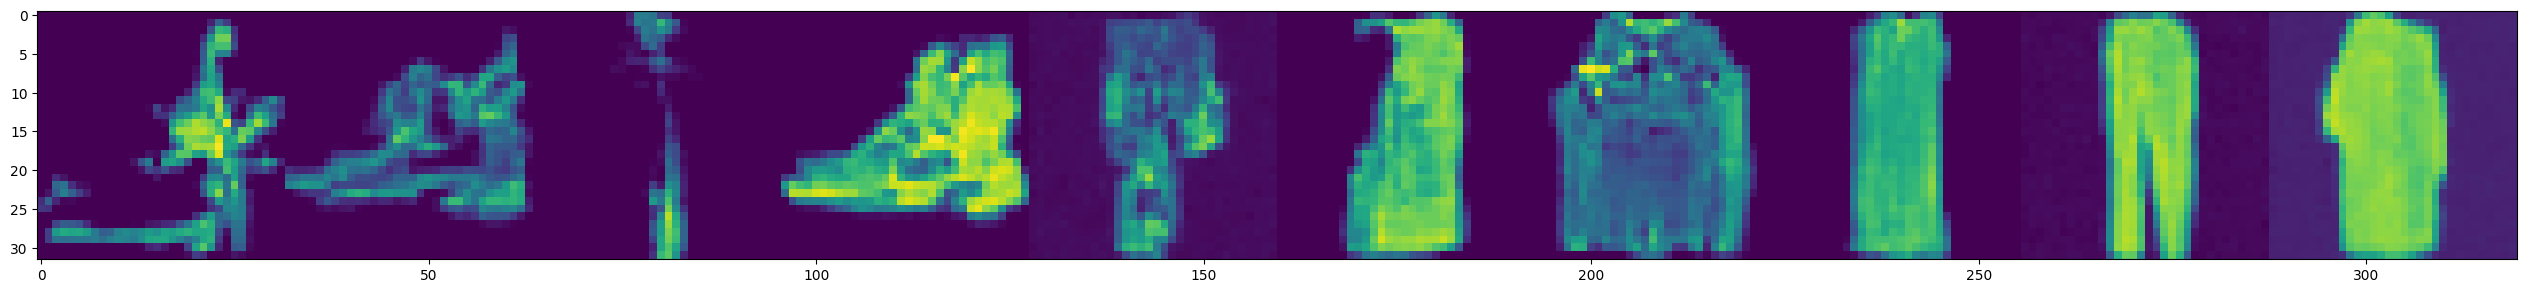

Sampling 10 new images...


0it [00:00, ?it/s]

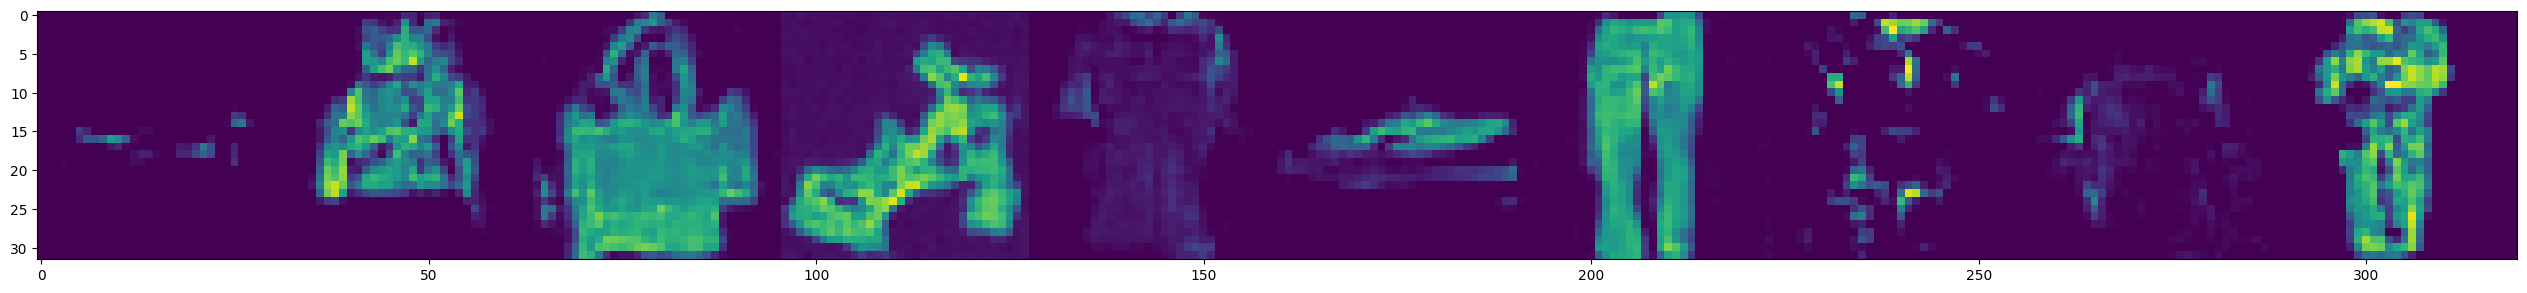

Sampling 10 new images...


0it [00:00, ?it/s]

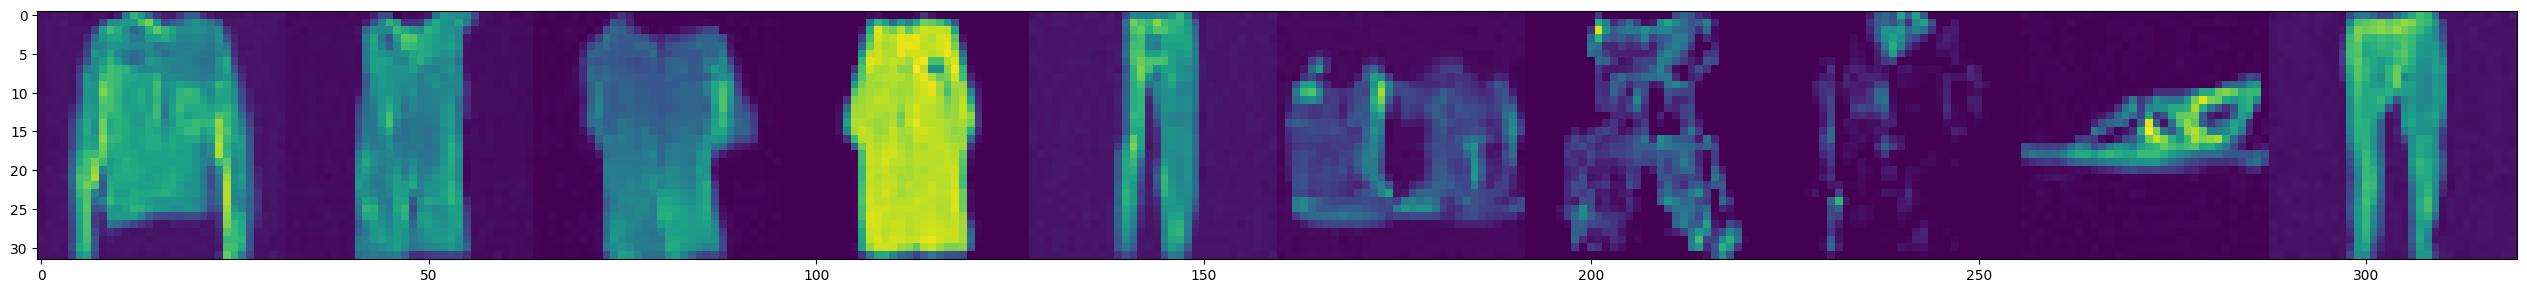

Sampling 10 new images...


0it [00:00, ?it/s]

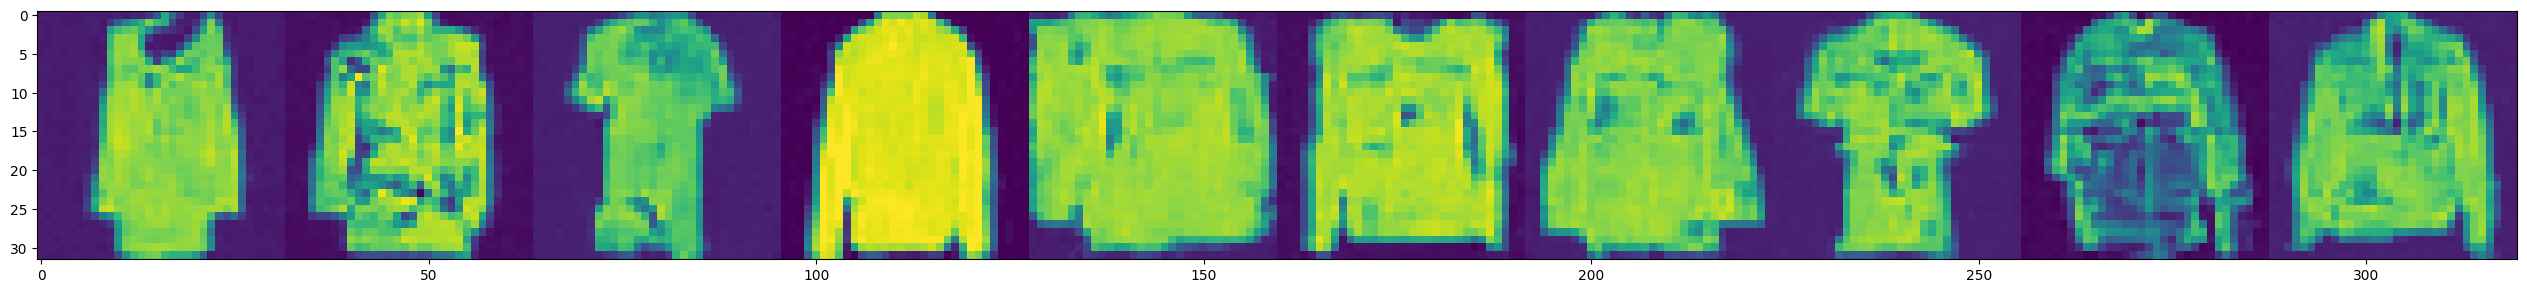

Sampling 10 new images...


0it [00:00, ?it/s]

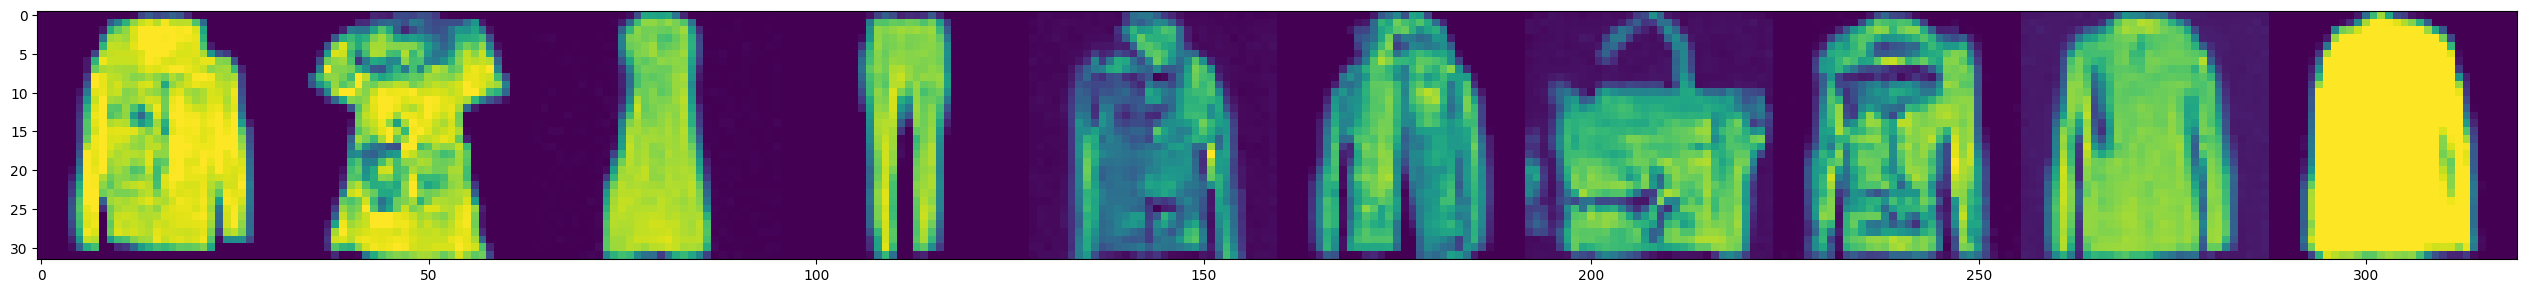

Sampling 10 new images...


0it [00:00, ?it/s]

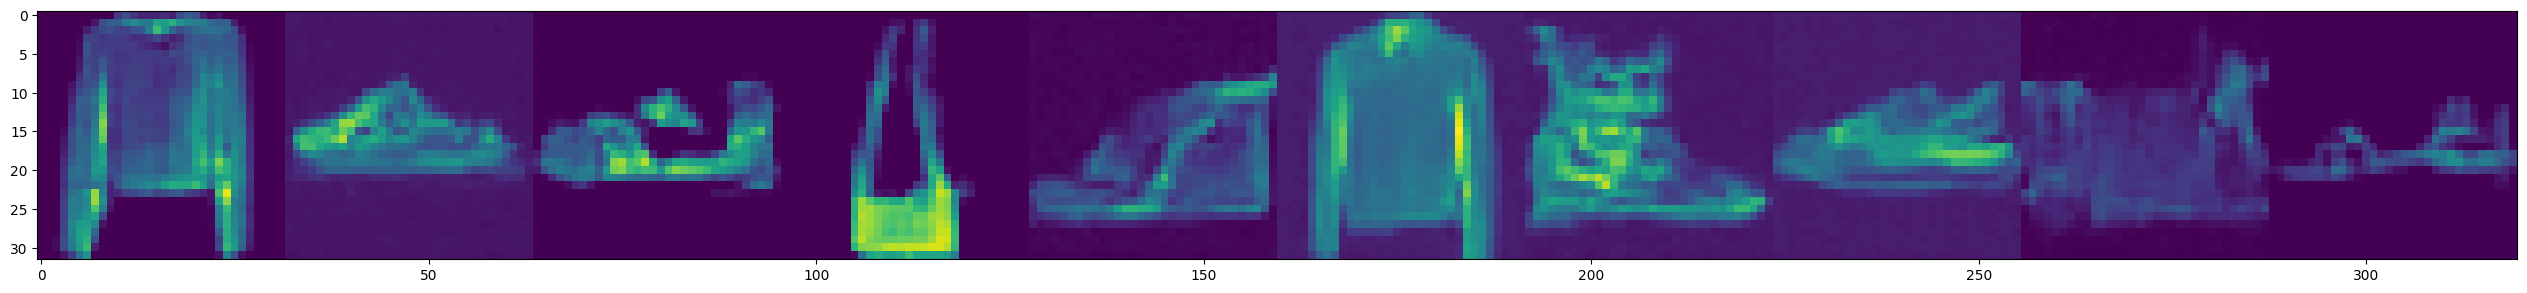

Sampling 10 new images...


0it [00:00, ?it/s]

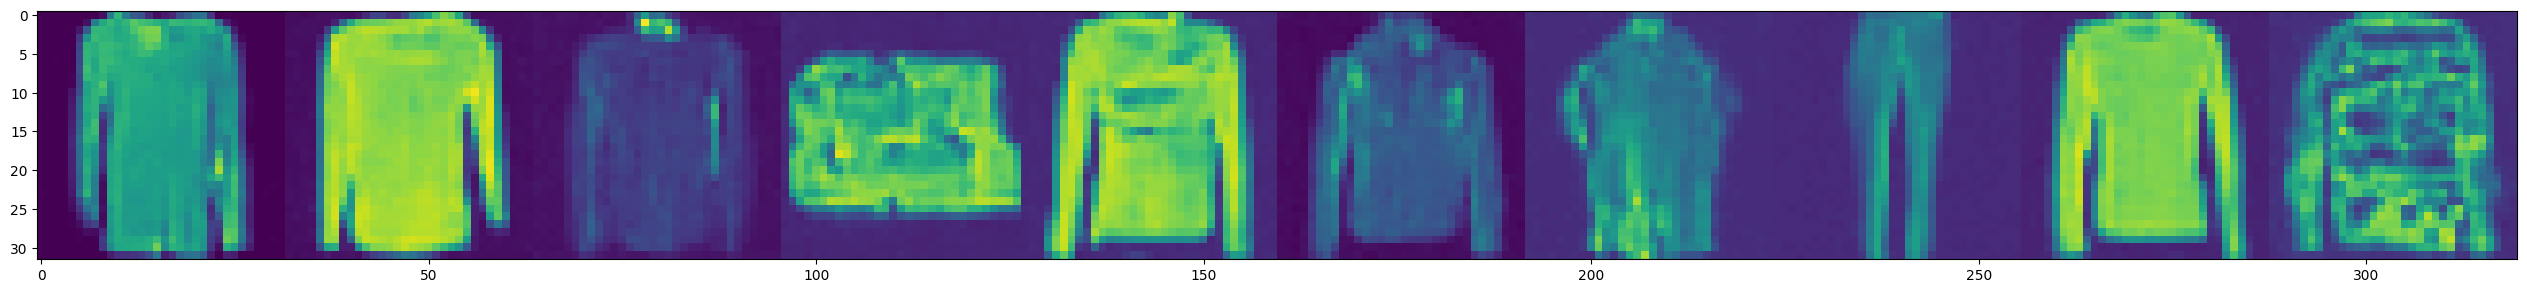

Sampling 10 new images...


0it [00:00, ?it/s]

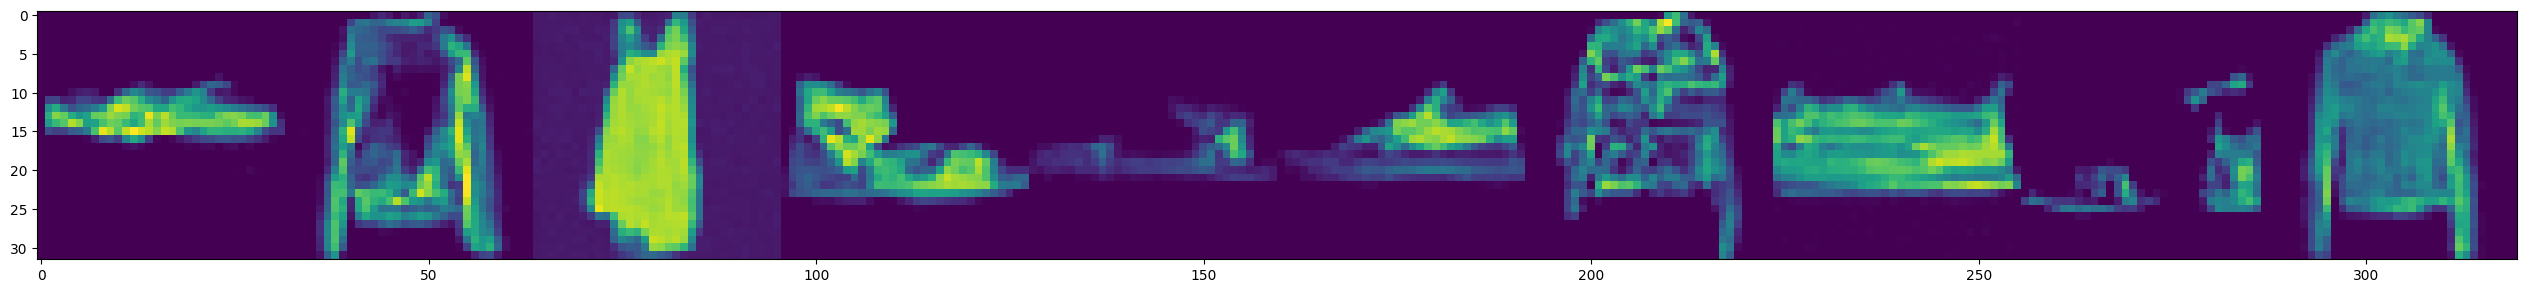

Sampling 10 new images...


0it [00:00, ?it/s]

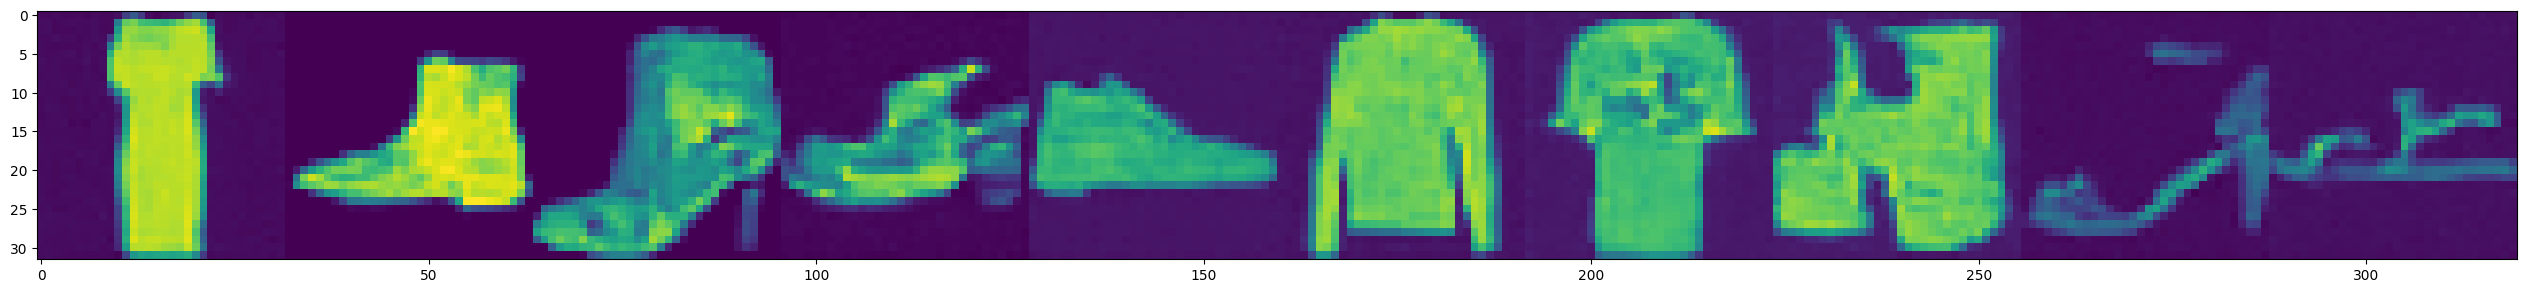

Sampling 10 new images...


0it [00:00, ?it/s]

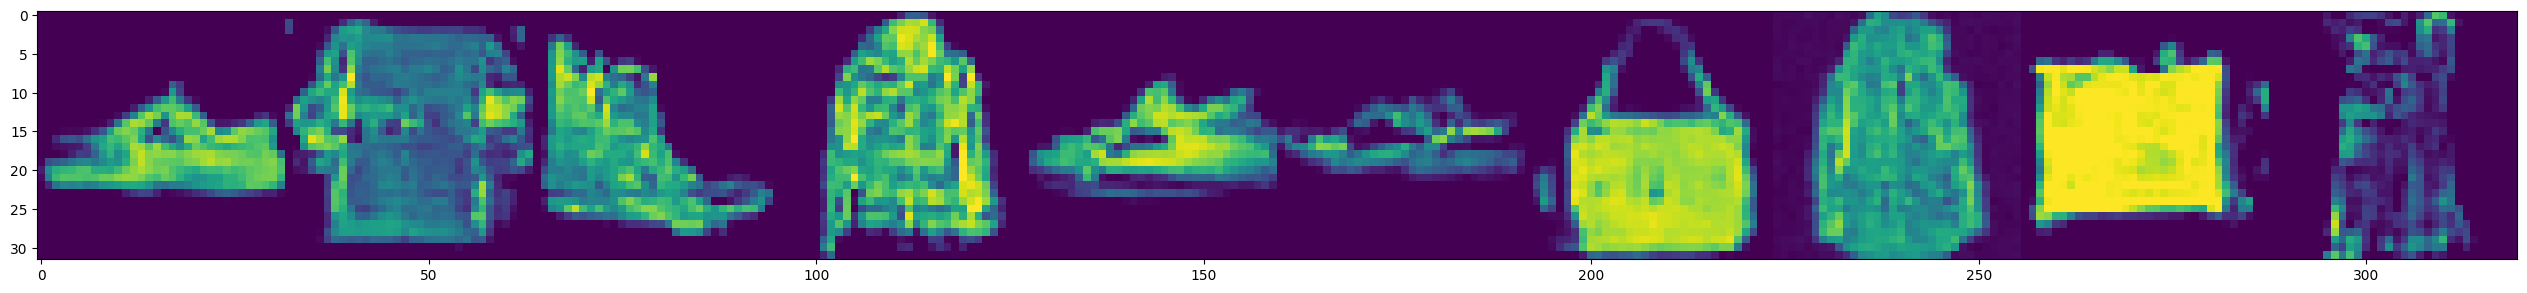

Sampling 10 new images...


0it [00:00, ?it/s]

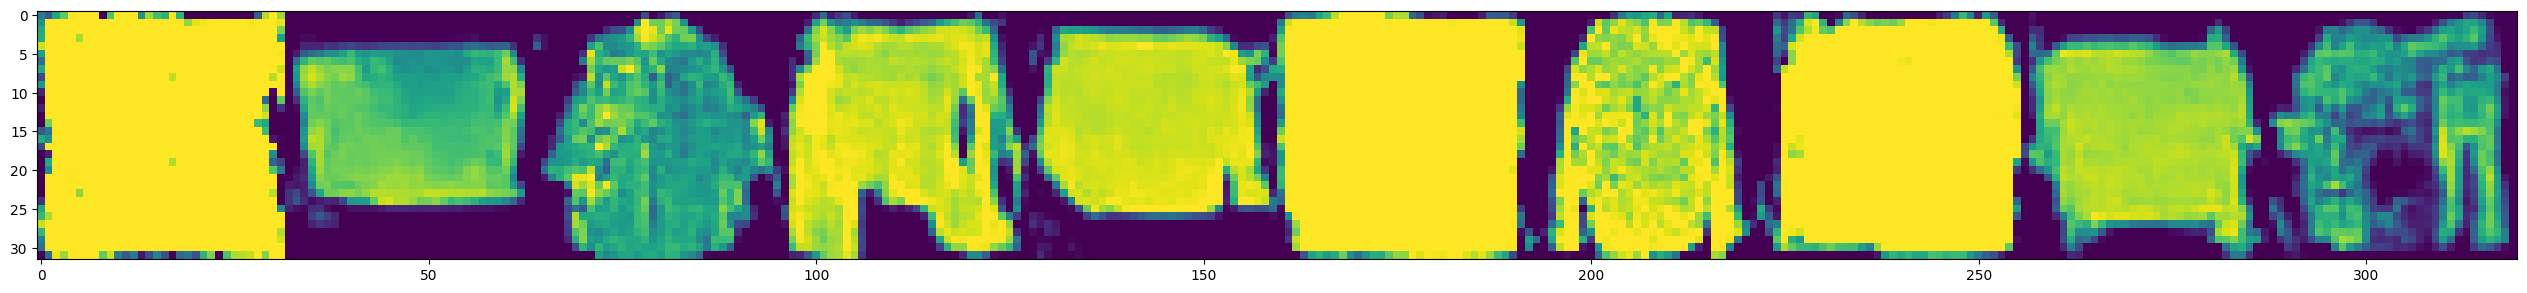

Sampling 10 new images...


0it [00:00, ?it/s]

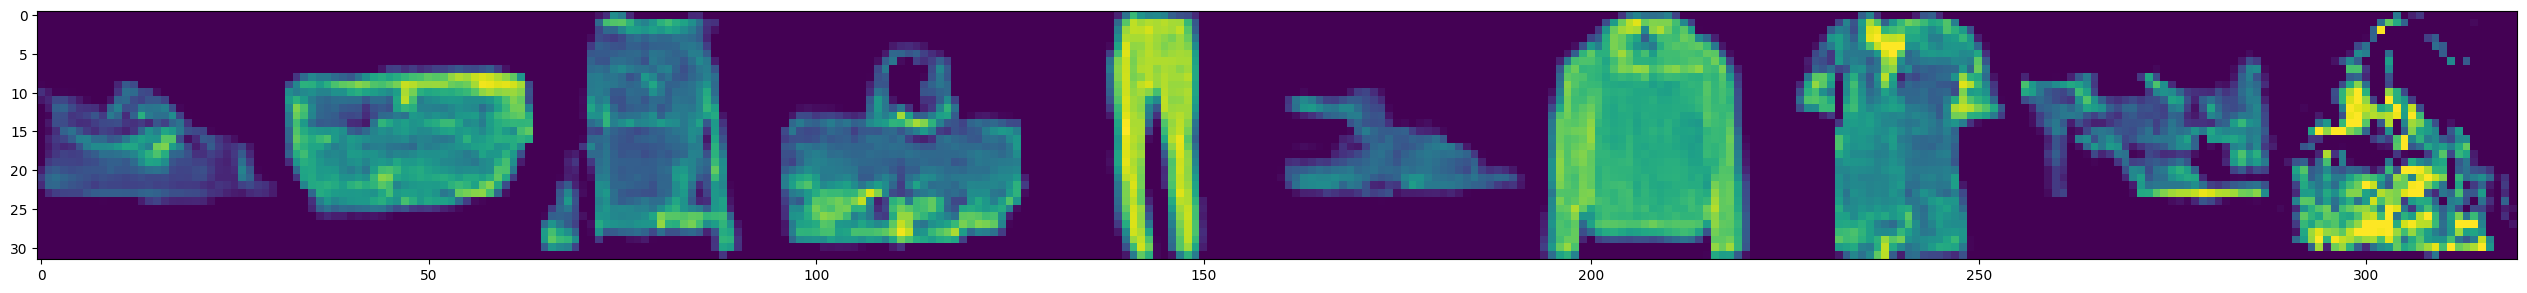

Sampling 10 new images...


0it [00:00, ?it/s]

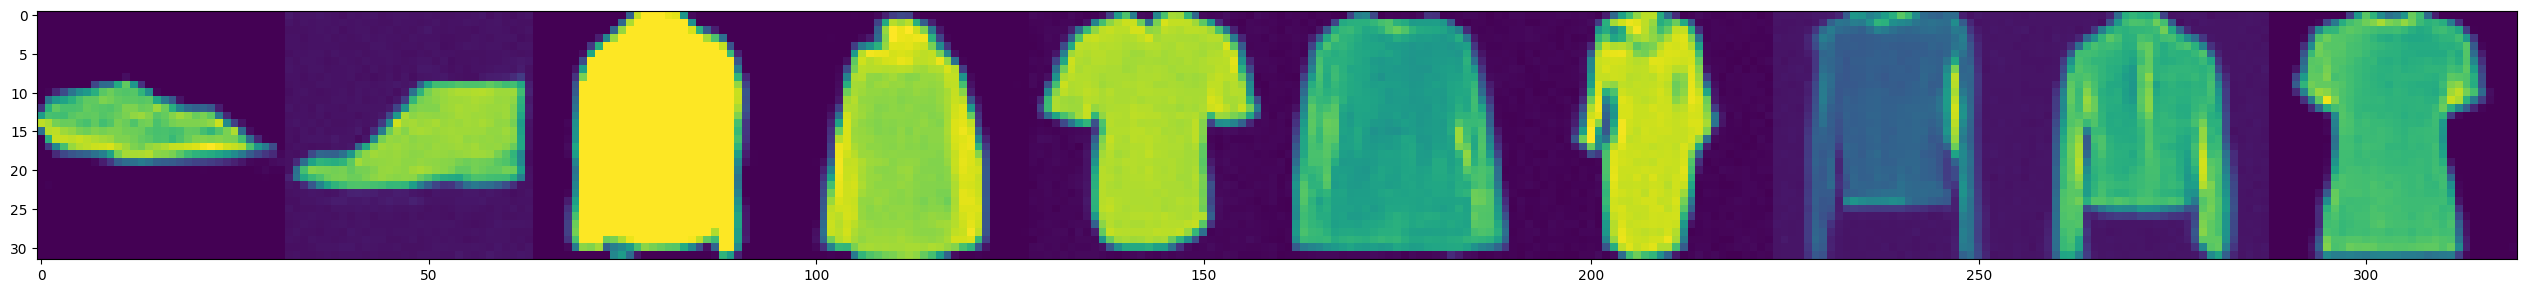

In [ ]:
start_from_checkpoint = False

if start_from_checkpoint:
    # Load the model from a checkpoint file
    checkpoint_path = "./model/last.ckpt"
    trained_model = UNet.load_from_checkpoint(checkpoint_path)
    print("Starting from checkpoint...")
else:
    # Setup DataModule, Model, and Trainer
    model = UNet()  # Initialize your model
    print("Starting from scratch...")

# Initialize Callbacks
checkpoint_callback = ModelCheckpoint(dirpath="./model", monitor="val_loss", mode="min", save_top_k=1, save_last=True)
lr_monitor = LearningRateMonitor(logging_interval='step')

# Initialize Logger
directory = os.path.dirname("./tb_logs/unet_unconditional")
os.makedirs(directory, exist_ok=True)
logger = TensorBoardLogger("tb_logs", name="unet_unconditional")

trainer = L.Trainer(
    max_epochs=50,
    accelerator="gpu",
    devices=1,  # Number of GPUs
    precision=16,  # Enable mixed precision training
    callbacks=[checkpoint_callback, lr_monitor],
    logger=logger
)

# Train
trainer.fit(model=model, train_dataloaders=fashion_mnist_dm)


### Generating New Images

In [ ]:
# Load the model from a checkpoint file
checkpoint_path = "./model/last.ckpt"
trained_model = UNet.load_from_checkpoint(checkpoint_path)

Sampling 8 new images...


0it [00:00, ?it/s]

torch.Size([8, 1, 32, 32])


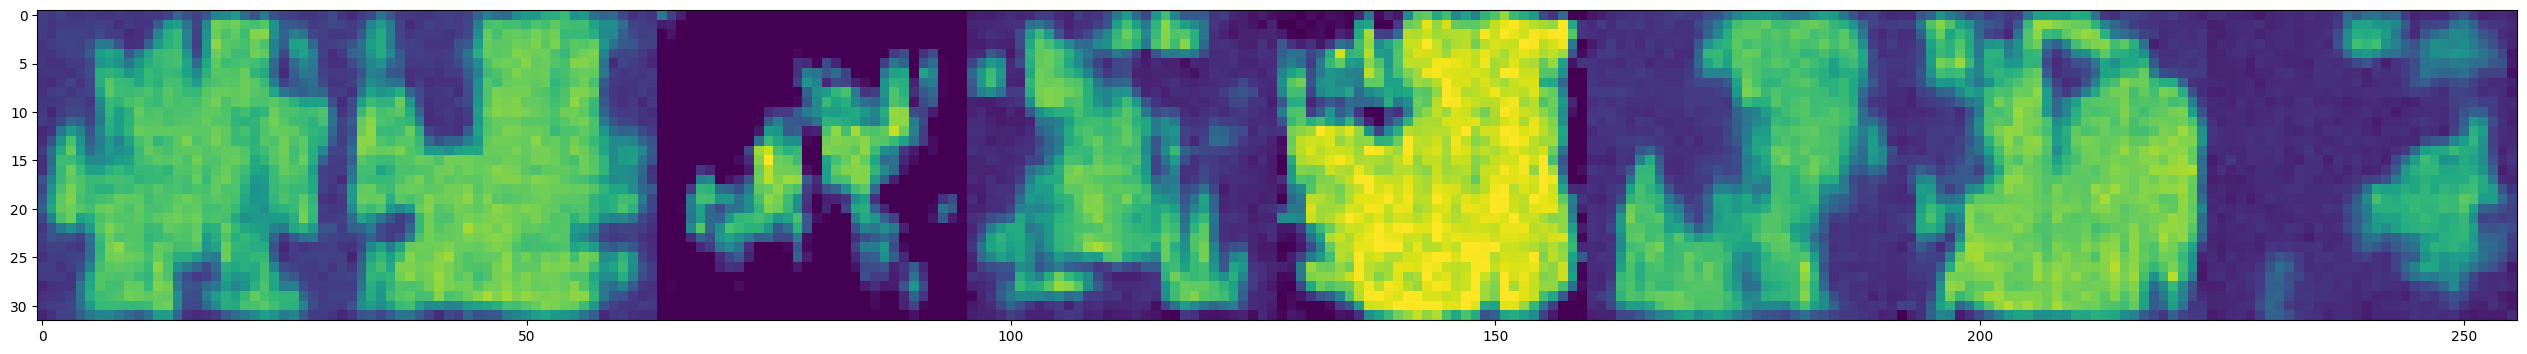

In [ ]:
diffusion = Diffusion(img_size=32, device=device)
x = diffusion.sample(trained_model, 8, input_channel=1)
print(x.shape)
plt.figure(figsize=(32, 32))
plt.imshow(torch.cat([
    torch.cat([i for i in x.cpu()], dim=-1),
], dim=-2).permute(1, 2, 0).cpu())
plt.show()

## Exploring Different Architectures Based on Diffusion Models

The initial diffusion models, often associated with works like "Deep Unsupervised Learning using Nonequilibrium Thermodynamics" by Jascha Sohl-Dickstein et al., and further popularized by Jonathan Ho et al. in "Denoising Diffusion Probabilistic Models" (DDPM), introduced a novel approach to generative modeling. These models work by gradually adding noise to data until it reaches a pure noise distribution and then learning to reverse this process to generate data from noise. This approach has shown remarkable success in generating high-quality samples, rivaling other generative models like GANs (Generative Adversarial Networks) and VAEs (Variational Autoencoders).


### Main Features of the Initial Diffusion Models Paper (DDPM)




1. **Diffusion Process**: The model transforms data into noise through a predefined diffusion process, which is essentially a Markov chain of small Gaussian noise additions.
2. **Reverse Process**: It learns a reverse generative process to reconstruct the original data from the noise, effectively learning to denoise.
3. **Training Objective**: The training involves optimizing a variational lower bound, which indirectly maximizes the likelihood of the data.
4. **Flexibility and Stability**: Compared to GANs, diffusion models are more stable during training and less prone to mode collapse, offering a wide range of generated diversity.
5. **Quality and Diversity**: Initial models demonstrated the potential for high-quality and diverse sample generation across different data types, including images and audio.

### Improvements Over the Initial Diffusion Models

Since the initial papers, there have been numerous improvements and innovations in diffusion models, making them more efficient, versatile, and capable of generating even higher quality outputs.

1. **Efficiency Improvements**:
   - **Learned Variance Schedules**: Subsequent works have proposed learning the noise schedule directly, which can lead to faster convergence and better sample quality.
   - **Conditioning Augmentation**: Techniques to condition the diffusion process on auxiliary information (like class labels or text descriptions) have been developed to guide the generation process more effectively.

2. **Architecture Innovations**:
   - **Attention Mechanisms**: Incorporating attention mechanisms, such as those used in Transformers, has significantly improved the model's ability to capture long-range dependencies and generate more coherent and detailed samples.
   - **Hybrid Models**: Combining diffusion models with other generative frameworks, like GANs or VAEs, to leverage the strengths of each approach.

3. **Application Expansion**:
   - **Beyond Images**: While initial models focused primarily on images, recent works have successfully applied diffusion models to a variety of other domains, including natural language processing, 3D generation, and audio synthesis.

4. **Sampling Efficiency**:
   - **Distillation Techniques**: Techniques to distill the diffusion process into fewer steps or even into a single neural network have been developed, significantly reducing the computational cost of generating samples.
   - **Improved Sampling Algorithms**: New algorithms that require fewer steps to generate high-quality samples by optimizing the sampling process itself.

## Conclusion

Looking forward, diffusion models hold immense potential to redefine the landscape of generative deep learning. As researchers continue to unravel the theoretical underpinnings and explore new variations, these models are poised to become even more powerful and efficient. Innovations such as optimizing the noise schedule, integrating multimodal data, and enhancing the interpretability of the generation process will likely drive further advancements. Additionally, the application of diffusion models in unsolved or complex domains, like three-dimensional generation and interactive content creation, opens new horizons for creative and practical applications. The evolving capabilities of diffusion models not only promise to expand the boundaries of generative deep learning but also offer a glimpse into the future where generation and simulation of realistic data can be achieved with unprecedented fidelity and control.

## References

  - [Denoising Diffusion Probabilistic Models:](https://arxiv.org/pdf/2006.11239.pdf)

  - Diffusion Model Implementation by [dome272](https://github.com/dome272) : (https://github.com/dome272/Diffusion-Models-pytorch/tree/main)
  - Paper explanation of Diffusion Models by Outlier: (https://www.youtube.com/watch?v=HoKDTa5jHvg)

  - [Improved Denoising Diffusion Probabilistic Modelsc (Nichol et al., 2021)](https://arxiv.org/pdf/2102.09672.pdf) : finds that learning the variance of the conditional distribution (besides the mean) helps in improving performance

  - [Cascaded Diffusion Models for High Fidelity Image Generation (Ho et al., 2021)](https://arxiv.org/abs/2106.15282): introduces cascaded diffusion, which comprises a pipeline of multiple diffusion models that generate images of increasing resolution for high-fidelity image synthesis

  - [Diffusion Models Beat GANs on Image Synthesis (Dhariwal et al., 2021)](https://arxiv.org/abs/2105.05233): show that diffusion models can achieve image sample quality superior to the current state-of-the-art generative models by improving the U-Net architecture, as well as introducing classifier guidance

  - [Classifier-Free Diffusion Guidance (Ho et al., 2021)](https://openreview.net/pdf?id=qw8AKxfYbI): shows that you don't need a classifier for guiding a diffusion model by jointly training a conditional and an unconditional diffusion model with a single neural network
  
  - [Hierarchical Text-Conditional Image Generation with CLIP Latents (DALL-E 2) (Ramesh et al., 2022)](https://cdn.openai.com/papers/dall-e-2.pdf): uses a prior to turn a text caption into a CLIP image embedding, after which a diffusion model decodes it into an image
  
  - [Photorealistic Text-to-Image Diffusion Models with Deep Language Understanding (ImageGen) (Saharia et al., 2022)](https://arxiv.org/abs/2205.11487): shows that combining a large pre-trained language model (e.g. T5) with cascaded diffusion works well for text-to-image synthesis